
# DAILY STOCK CLOSING PRICE PREDICTION USING LSTM AND XGBoost


***

> Python notebook supporting thesis based on the daily stock price prediction using machine learning and deep learning algorithms
>
>> By **Denis Roystan Richard Dalmeida (<denisroystan01@gmail.com>)**

***

#### Remove Warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')

> #### Load Libraries

In [2]:
!pip install -U scikit-learn
!pip install mplfinance

     |████████████████████████████████| 22.3 MB 60.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 62 kB 757 kB/s 


In [3]:
%matplotlib inline

# Import the numpy and pandas packages
import numpy as np
import pandas as pd

# Date Functions
from datetime import date, timedelta, datetime

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn packages
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Deep learning library, used for neural networks
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

# XGBoost packages
import xgboost as xgb
from xgboost import plot_importance

# Candlestick Chart
import mplfinance as mpf

# Plot a horizontal line
from IPython.display import Markdown, display

# Mathematical functions
import math

> #### Helper Functions

In [4]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def get_stock_name(stock):
    print('\033[1m' + get_df_name(stock) + '\033[0m')

> #### Import and read Datasets

In [5]:
# Adani Ports and Special Economic Zone Ltd
ADANIPORTS = pd.read_csv('./data/ADANI+PORTS+AND+SPECIAL+ECONOMIC+ZONE+LTD.csv', parse_dates=["Date"])
ADANIPORTS = ADANIPORTS.sort_values(by='Date')
ADANIPORTS = ADANIPORTS.reset_index(drop=True)

# Glenmark Pharmaceuticals Ltd
GLENMARK = pd.read_csv('./data/GLENMARK+PHARMACEUTICALS+LTD.csv', parse_dates=["Date"])
GLENMARK = GLENMARK.sort_values(by='Date')
GLENMARK = GLENMARK.reset_index(drop=True)

# Indiabulls Housing Finance Ltd
IBULHSGFIN = pd.read_csv('./data/INDIABULLS+HOUSING+FINANCE+LTD.csv', parse_dates=["Date"])
IBULHSGFIN = IBULHSGFIN.sort_values(by='Date')
IBULHSGFIN = IBULHSGFIN.reset_index(drop=True)

# Infosys Ltd
INFY = pd.read_csv('./data/INFOSYS+LTD.csv', parse_dates=["Date"])
INFY = INFY.sort_values(by='Date')
INFY = INFY.reset_index(drop=True)

# Maruti Suzuki India Ltd
MARUTI = pd.read_csv('./data/MARUTI+SUZUKI+INDIA+LTD.csv', parse_dates=["Date"])
MARUTI = MARUTI.sort_values(by='Date')
MARUTI = MARUTI.reset_index(drop=True)

In [6]:
# List of companies
stock_list = [ADANIPORTS, GLENMARK, IBULHSGFIN, INFY, MARUTI]

In [7]:
for stock in stock_list:
    get_stock_name(stock)
    display(stock.head(5))

ADANIPORTS


,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open
0,2011-01-03,145.95,146.45,144.20,144.75,145.186425,85627,1098,12431878.0,39968.0,46.68,2.25,-1.20
1,2011-01-04,146.00,150.00,144.05,148.25,147.248980,196807,2016,28979630.0,85782.0,43.59,5.95,2.25
2,2011-01-05,150.00,158.60,149.45,157.55,154.834965,1103066,11207,170793186.0,327906.0,29.73,9.15,7.55
3,2011-01-06,159.00,159.90,153.50,154.65,157.003808,490608,5474,77027324.0,97503.0,19.87,6.40,-4.35
4,2011-01-07,155.00,155.25,146.65,147.60,150.254998,224053,3181,33665083.0,69927.0,31.21,8.60,-7.40


GLENMARK


,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open
0,2011-01-03,364.0,370.30,355.55,357.40,364.513776,145976,2869,53210263.0,65280.0,44.72,14.75,-6.60
1,2011-01-04,359.1,367.00,359.10,364.50,364.109291,71433,1899,26009419.0,21013.0,29.42,7.90,5.40
2,2011-01-05,365.5,369.25,359.25,364.25,364.323722,71339,1826,25990490.0,37846.0,53.05,10.00,-1.25
3,2011-01-06,367.0,372.10,361.20,367.20,367.728044,75218,1723,27659768.0,33310.0,44.28,10.90,0.20
4,2011-01-07,368.0,369.35,356.05,358.90,361.450291,54749,1491,19789042.0,16572.0,30.27,13.30,-9.10


IBULHSGFIN


,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open
0,2013-07-23,270.00,283.50,263.30,283.40,274.356720,873272,2442,239588042.0,873272.0,100.0,20.20,13.40
1,2013-07-24,285.00,285.00,269.25,269.25,269.719206,458176,5381,123578867.0,458176.0,100.0,15.75,-15.75
2,2013-07-25,255.80,255.80,255.80,255.80,255.799999,677932,252,173415005.0,677932.0,100.0,0.00,0.00
3,2013-07-26,243.05,243.05,243.05,243.05,243.049999,632636,63,153762179.0,632636.0,100.0,0.00,0.00
4,2013-07-29,230.90,235.00,230.90,230.90,230.906664,2226329,442,514074203.0,2226329.0,100.0,4.10,0.00


INFY


,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open
0,2011-01-03,3449.0,3458.85,3427.0,3452.90,3445.424991,48314,2797,166462263.0,13866.0,28.70,31.85,3.90
1,2011-01-04,3453.0,3489.90,3453.0,3468.00,3475.226844,61042,3954,212134797.0,16148.0,26.45,36.90,15.00
2,2011-01-05,3464.7,3476.00,3447.0,3467.65,3464.992952,39728,2708,137657240.0,8243.0,20.75,29.00,2.95
3,2011-01-06,3473.0,3492.00,3444.0,3475.85,3473.070830,95764,3206,332595155.0,53913.0,56.30,48.00,2.85
4,2011-01-07,3475.0,3493.95,3356.0,3366.50,3420.086561,97931,4933,334932497.0,21935.0,22.40,137.95,-108.50


MARUTI


,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open
0,2011-01-03,1430.00,1450.0,1421.30,1427.65,1435.255938,50942,2333,73114808.0,6570.0,12.90,28.70,-2.35
1,2011-01-04,1437.95,1452.2,1405.15,1429.25,1422.254473,153545,3200,218380063.0,105165.0,68.49,47.05,-8.70
2,2011-01-05,1427.00,1435.0,1412.00,1415.10,1421.698201,31352,1513,44573082.0,5236.0,16.70,23.00,-11.90
3,2011-01-06,1425.00,1425.0,1366.00,1372.85,1389.174954,44343,2129,61600185.0,16591.0,37.42,59.00,-52.15
4,2011-01-07,1384.00,1384.0,1340.05,1343.60,1353.472390,71026,2138,96131730.0,39743.0,55.96,43.95,-40.40


> #### Dataset Inspection

In [8]:
for stock in stock_list:
    get_stock_name(stock)
    display(stock.info())

ADANIPORTS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       2479 non-null   datetime64[ns]
 1   Open Price                 2479 non-null   float64       
 2   High Price                 2479 non-null   float64       
 3   Low Price                  2479 non-null   float64       
 4   Close Price                2479 non-null   float64       
 5   WAP                        2479 non-null   float64       
 6   No.of Shares               2479 non-null   int64         
 7   No. of Trades              2479 non-null   int64         
 8   Total Turnover (Rs.)       2479 non-null   float64       
 9   Deliverable Quantity       2478 non-null   float64       
 10  % Deli. Qty to Traded Qty  2478 non-null   float64       
 11  Spread High-Low            2479 non-null   float64       


None

GLENMARK
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       2479 non-null   datetime64[ns]
 1   Open Price                 2479 non-null   float64       
 2   High Price                 2479 non-null   float64       
 3   Low Price                  2479 non-null   float64       
 4   Close Price                2479 non-null   float64       
 5   WAP                        2479 non-null   float64       
 6   No.of Shares               2479 non-null   int64         
 7   No. of Trades              2479 non-null   int64         
 8   Total Turnover (Rs.)       2479 non-null   float64       
 9   Deliverable Quantity       2478 non-null   float64       
 10  % Deli. Qty to Traded Qty  2478 non-null   float64       
 11  Spread High-Low            2479 non-null   float64       
 1

None

IBULHSGFIN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1840 entries, 0 to 1839
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       1840 non-null   datetime64[ns]
 1   Open Price                 1840 non-null   float64       
 2   High Price                 1840 non-null   float64       
 3   Low Price                  1840 non-null   float64       
 4   Close Price                1840 non-null   float64       
 5   WAP                        1840 non-null   float64       
 6   No.of Shares               1840 non-null   int64         
 7   No. of Trades              1840 non-null   int64         
 8   Total Turnover (Rs.)       1840 non-null   float64       
 9   Deliverable Quantity       1839 non-null   float64       
 10  % Deli. Qty to Traded Qty  1839 non-null   float64       
 11  Spread High-Low            1840 non-null   float64       


None

INFY
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       2479 non-null   datetime64[ns]
 1   Open Price                 2479 non-null   float64       
 2   High Price                 2479 non-null   float64       
 3   Low Price                  2479 non-null   float64       
 4   Close Price                2479 non-null   float64       
 5   WAP                        2479 non-null   float64       
 6   No.of Shares               2479 non-null   int64         
 7   No. of Trades              2479 non-null   int64         
 8   Total Turnover (Rs.)       2479 non-null   float64       
 9   Deliverable Quantity       2478 non-null   float64       
 10  % Deli. Qty to Traded Qty  2478 non-null   float64       
 11  Spread High-Low            2479 non-null   float64       
 12  S

None

MARUTI
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       2479 non-null   datetime64[ns]
 1   Open Price                 2479 non-null   float64       
 2   High Price                 2479 non-null   float64       
 3   Low Price                  2479 non-null   float64       
 4   Close Price                2479 non-null   float64       
 5   WAP                        2479 non-null   float64       
 6   No.of Shares               2479 non-null   int64         
 7   No. of Trades              2479 non-null   int64         
 8   Total Turnover (Rs.)       2479 non-null   float64       
 9   Deliverable Quantity       2478 non-null   float64       
 10  % Deli. Qty to Traded Qty  2478 non-null   float64       
 11  Spread High-Low            2479 non-null   float64       
 12 

None

>> ##### Dropping rows/columns with null values

In [9]:
for stock in stock_list:
    stock.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)

In [10]:
for stock in stock_list:
    get_stock_name(stock)
    display(stock.isnull().sum(axis = 0))

ADANIPORTS


Date                         0
Open Price                   0
High Price                   0
Low Price                    0
Close Price                  0
WAP                          0
No.of Shares                 0
No. of Trades                0
Total Turnover (Rs.)         0
Deliverable Quantity         0
% Deli. Qty to Traded Qty    0
Spread High-Low              0
Spread Close-Open            0
dtype: int64

GLENMARK


Date                         0
Open Price                   0
High Price                   0
Low Price                    0
Close Price                  0
WAP                          0
No.of Shares                 0
No. of Trades                0
Total Turnover (Rs.)         0
Deliverable Quantity         0
% Deli. Qty to Traded Qty    0
Spread High-Low              0
Spread Close-Open            0
dtype: int64

IBULHSGFIN


Date                         0
Open Price                   0
High Price                   0
Low Price                    0
Close Price                  0
WAP                          0
No.of Shares                 0
No. of Trades                0
Total Turnover (Rs.)         0
Deliverable Quantity         0
% Deli. Qty to Traded Qty    0
Spread High-Low              0
Spread Close-Open            0
dtype: int64

INFY


Date                         0
Open Price                   0
High Price                   0
Low Price                    0
Close Price                  0
WAP                          0
No.of Shares                 0
No. of Trades                0
Total Turnover (Rs.)         0
Deliverable Quantity         0
% Deli. Qty to Traded Qty    0
Spread High-Low              0
Spread Close-Open            0
dtype: int64

MARUTI


Date                         0
Open Price                   0
High Price                   0
Low Price                    0
Close Price                  0
WAP                          0
No.of Shares                 0
No. of Trades                0
Total Turnover (Rs.)         0
Deliverable Quantity         0
% Deli. Qty to Traded Qty    0
Spread High-Low              0
Spread Close-Open            0
dtype: int64

>> ##### Companies dataset shape (rows, columns)

In [11]:
for stock in stock_list:
    get_stock_name(stock)
    display(stock.shape)

ADANIPORTS


(2478, 13)

GLENMARK


(2478, 13)

IBULHSGFIN


(1839, 13)

INFY


(2478, 13)

MARUTI


(2478, 13)

> #### Exploratory Data Analysis

>> ##### Bloxplot

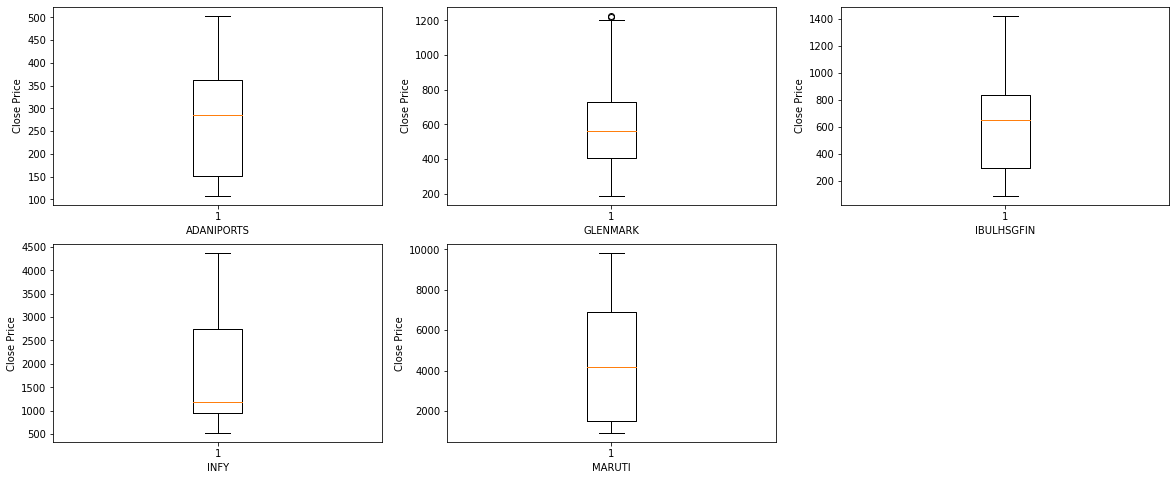

In [12]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)

for index, stock in enumerate(stock_list):
    plt.subplot(2, 3, index+1)
    plt.xlabel(get_df_name(stock))
    plt.ylabel('Close Price')
    plt.boxplot(stock['Close Price'])

plt.show()

>> ##### Scatter Plot

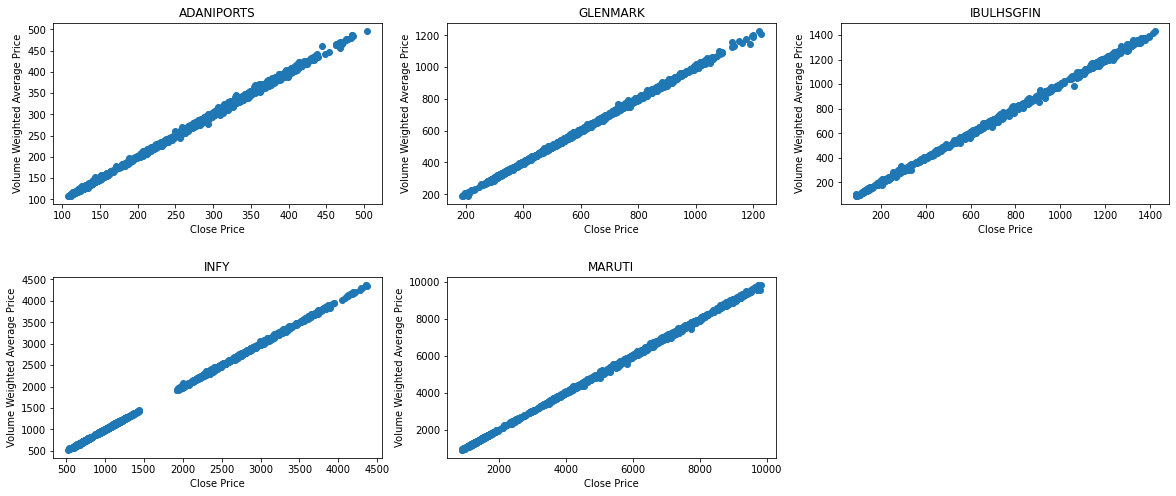

In [13]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)

for index, stock in enumerate(stock_list):
    plt.subplot(2, 3, index+1)
    plt.xlabel("Close Price")
    plt.ylabel("Volume Weighted Average Price")
    plt.scatter(stock['Close Price'], stock['WAP'])
    plt.title(get_df_name(stock))

plt.subplots_adjust(hspace=0.4)   
plt.show()

>> ##### Closing Price Line Chart

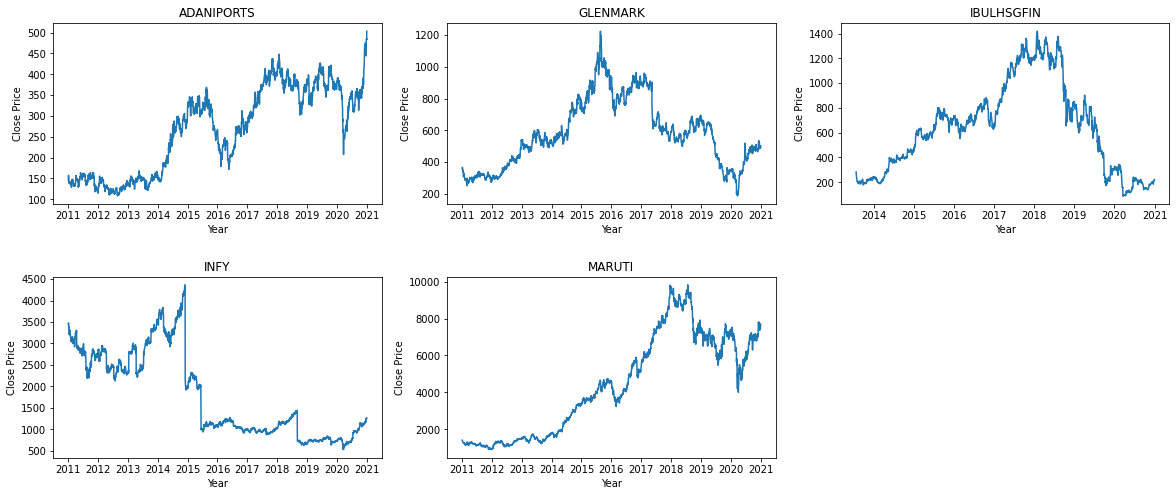

In [14]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)

for index, stock in enumerate(stock_list):
    plt.subplot(2, 3, index+1)
    plt.xlabel("Year")
    plt.ylabel("Close Price")
    plt.plot(stock['Date'], stock['Close Price'])
    plt.title(get_df_name(stock))
    
plt.subplots_adjust(hspace=0.4)   
plt.show()

>> ##### Total volume of stock being traded over decade

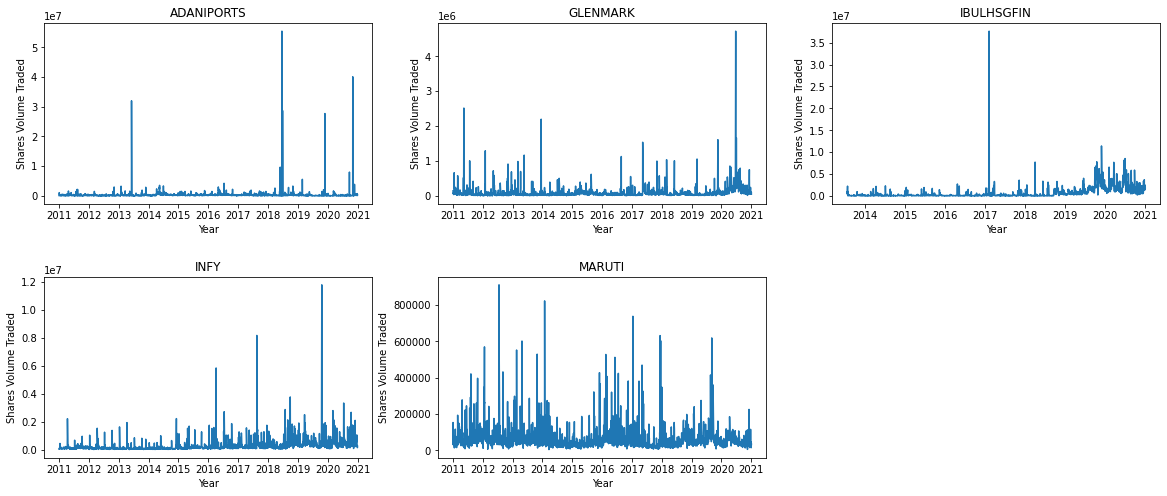

In [15]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)

for index, stock in enumerate(stock_list):
    plt.subplot(2, 3, index+1)
    plt.ylabel('Shares Volume Traded')
    plt.xlabel('Year')
    plt.plot(stock['Date'], stock['No.of Shares'])
    plt.title(get_df_name(stock))

plt.subplots_adjust(hspace=0.4)  
plt.show()

>> ##### Candle plot for period of Demonetization

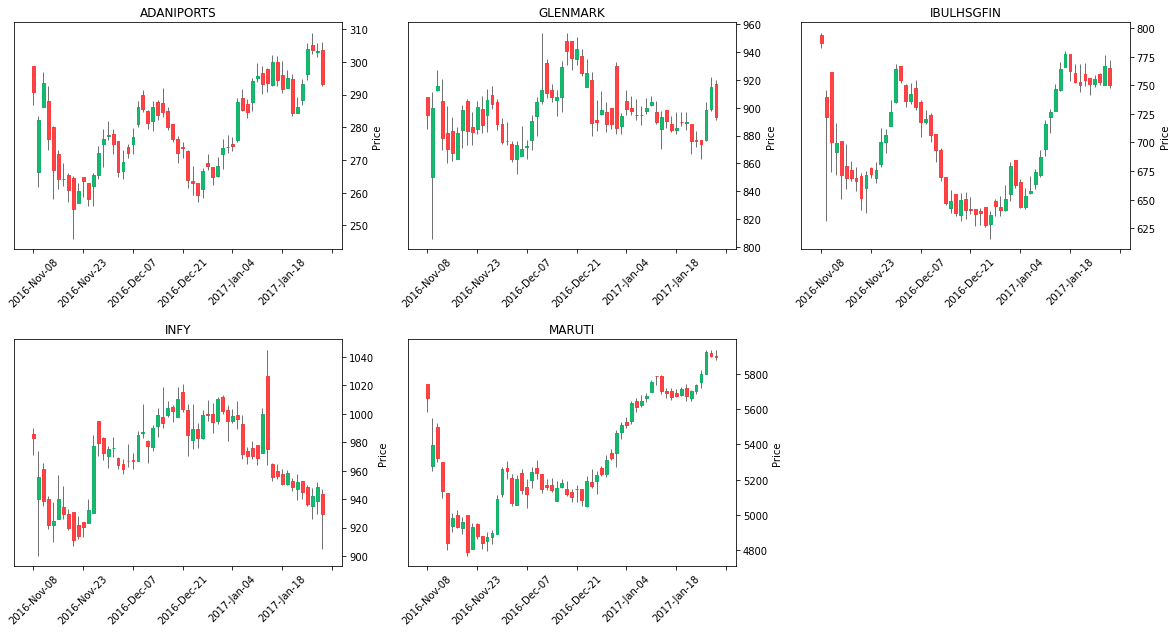

In [16]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

for index, stock in enumerate(stock_list):
    ax = plt.subplot(2, 3, index+1) 
    df = stock[['Date', 'Open Price', 'High Price', 'Low Price', 'Close Price']] # Selected required columns
    df.index = pd.DatetimeIndex(df['Date']) # Format index to datetime index
    df = df.loc['2016-11-08':'2017-01-31'] # Selected time period
    df.drop(['Date'], axis = 1, inplace=True) # Drop date column
    
    # Rename column for mplfinance library
    df.rename(columns={"Open Price": "Open", "High Price": "High", "Low Price": "Low", "Close Price": "Close"}, inplace=True)
    mpf.plot(df, type='candle', style='yahoo', ax=ax)
    plt.title(get_df_name(stock))
    
plt.subplots_adjust(hspace=0.4)  
plt.show()

>> ##### Candle plot for period of Covid

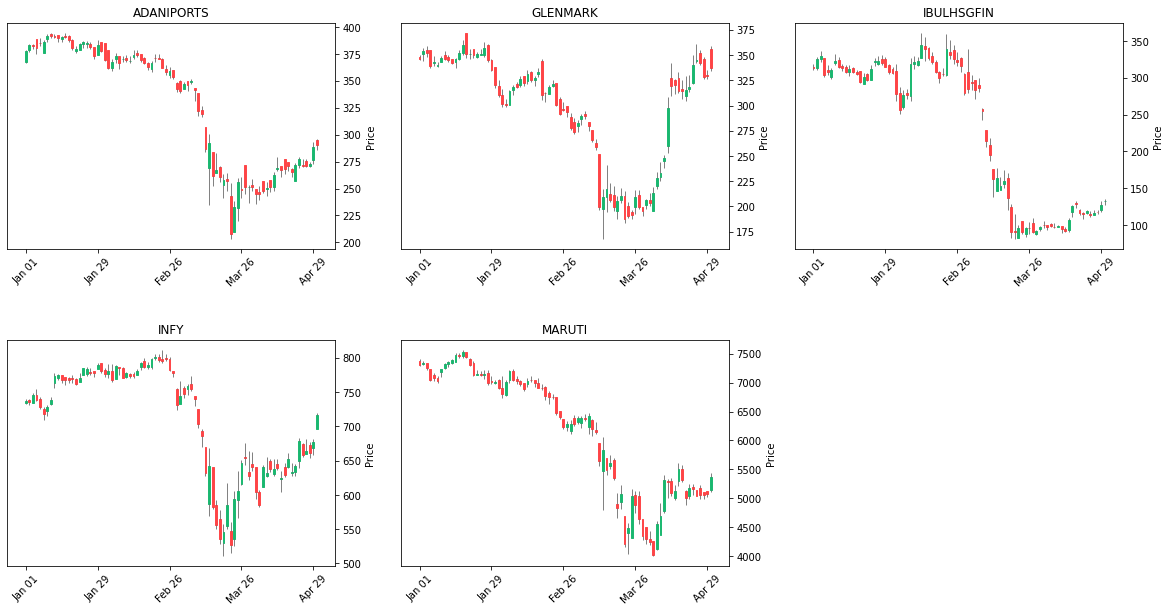

In [17]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

for index, stock in enumerate(stock_list):
    ax = plt.subplot(2, 3, index+1) 
    df = stock[['Date', 'Open Price', 'High Price', 'Low Price', 'Close Price']] # Selected required columns
    df.index = pd.DatetimeIndex(df['Date']) # Format index to datetime index
    df = df.loc['2020-01-01':'2020-04-30'] # Selected time period
    df.drop(['Date'], axis = 1, inplace=True) # Drop date column
    
    # Rename column for mplfinance library
    df.rename(columns={"Open Price": "Open", "High Price": "High", "Low Price": "Low", "Close Price": "Close"}, inplace=True)
    mpf.plot(df, type='candle', style='yahoo', ax=ax)
    plt.title(get_df_name(stock))
    
plt.subplots_adjust(hspace=0.4)  
plt.show()

>> ##### Relative Strength Index
RSI indicator to predict whether a stock is overbought/oversold

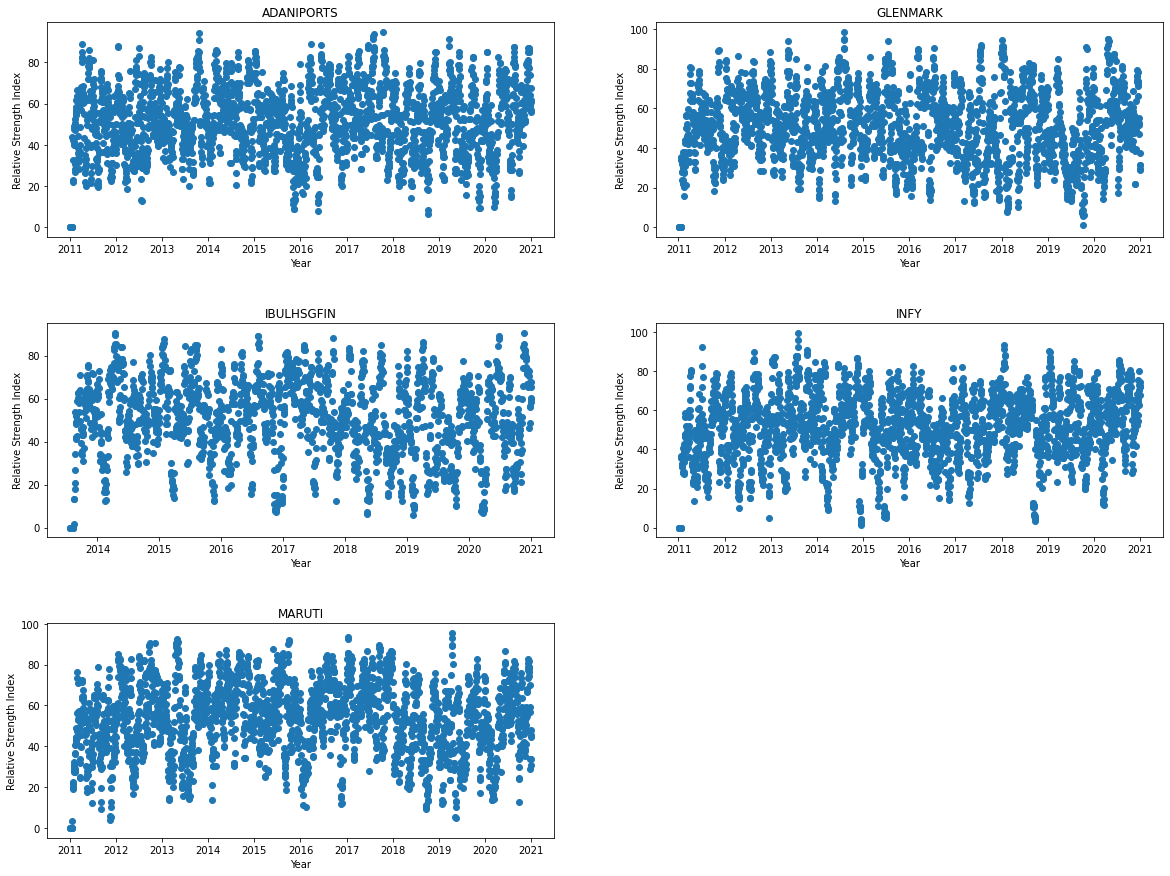

In [18]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)

def relative_strength_idx(df, n=14):
    close = df['Close Price']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

for index, stock in enumerate(stock_list):
    df = stock.copy(deep=True)
    df['RSI'] = relative_strength_idx(df).fillna(0)
    
    plt.subplot(3, 2, index+1)
    plt.xlabel("Year")
    plt.ylabel("Relative Strength Index")
    plt.scatter(df['Date'], df['RSI'])
    plt.title(get_df_name(stock))

plt.subplots_adjust(hspace=0.4)  
plt.show()

>> ##### Moving Averages

In [19]:
ma_day = [20, 50, 100, 200]

for ma in ma_day:
    for stock in stock_list:
        column_name = f"MA for {ma} days"
        stock[column_name] = stock['Close Price'].rolling(ma, min_periods=1).mean()

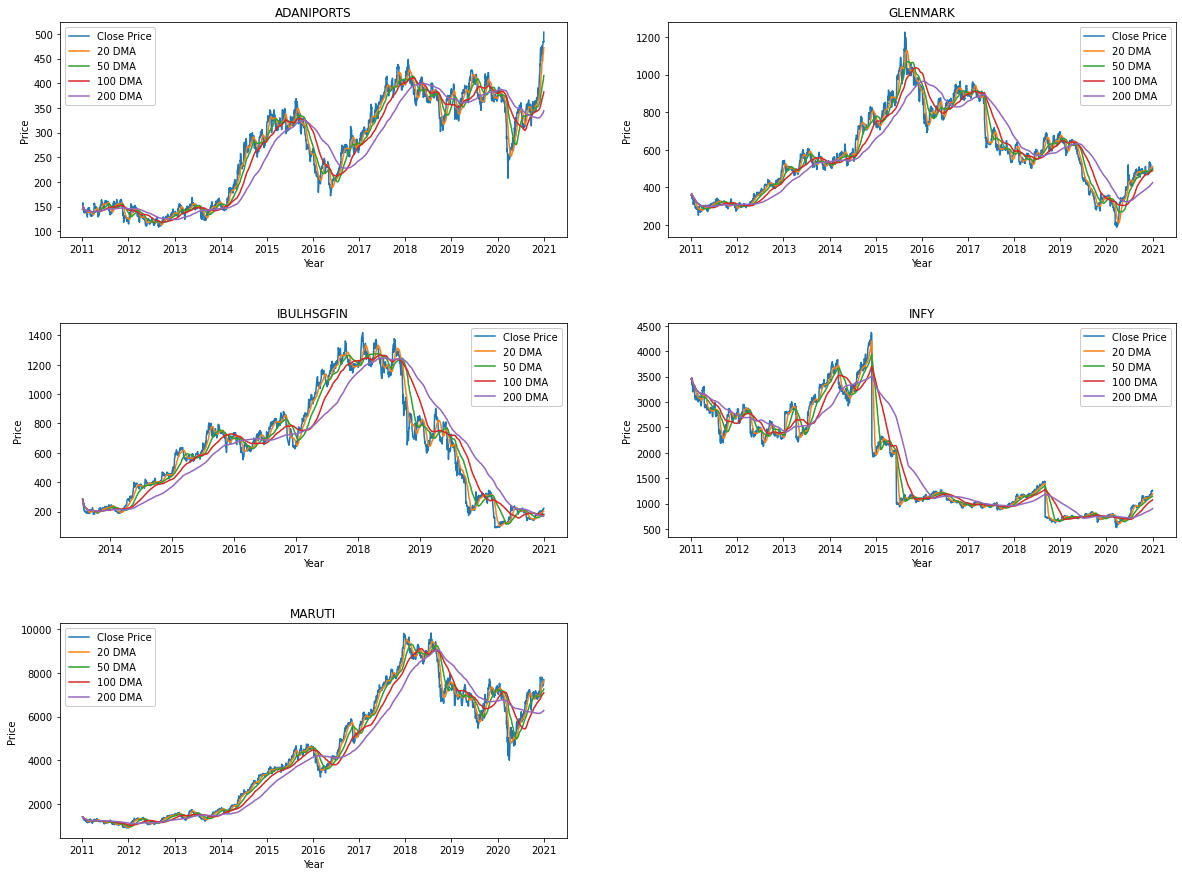

In [20]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)

for index, stock in enumerate(stock_list):
    plt.subplot(3, 2, index+1)
    plt.ylabel('Price')
    plt.xlabel('Year')
    plt.plot(stock['Date'], stock['Close Price'], label='Close Price')
    plt.plot(stock['Date'], stock['MA for 20 days'], label='20 DMA')
    plt.plot(stock['Date'], stock['MA for 50 days'], label='50 DMA')
    plt.plot(stock['Date'], stock['MA for 100 days'], label='100 DMA')
    plt.plot(stock['Date'], stock['MA for 200 days'], label='200 DMA')
    plt.legend(framealpha=1, frameon=True);
    plt.title(get_df_name(stock))

plt.subplots_adjust(hspace=0.4)  
plt.show()

>> ##### Daily Returns

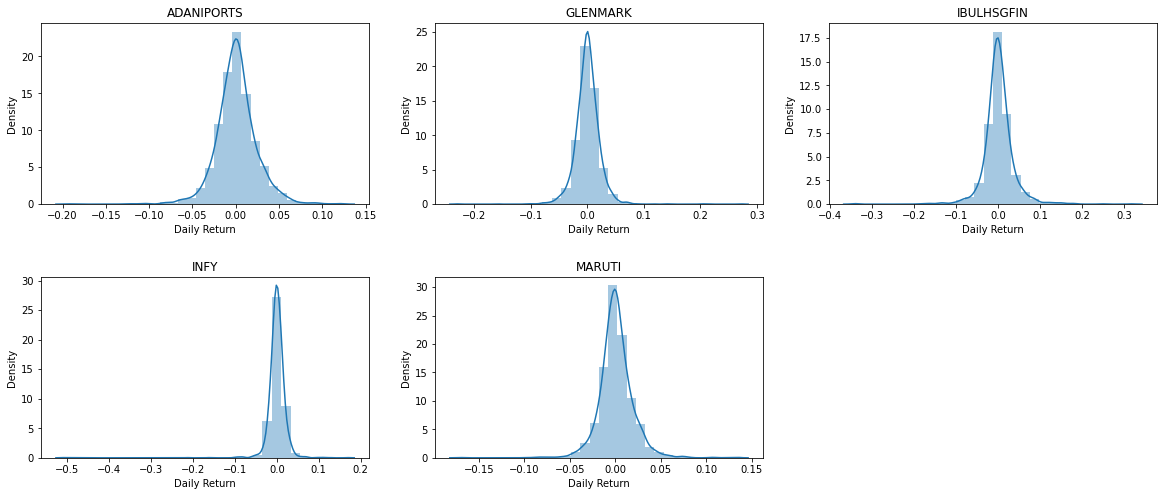

In [21]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)

# We'll use pct_change to find the percent change for each day
for index, stock in enumerate(stock_list):
    df = stock.copy(deep=True)
    df['Daily Return'] = df['Close Price'].pct_change()
    
    plt.subplot(2, 3, index+1)
    sns.distplot(df['Daily Return'], bins=30)
    plt.title(get_df_name(stock))

plt.subplots_adjust(hspace=0.4)  
plt.show()

>> ##### Price and Volume Correlation

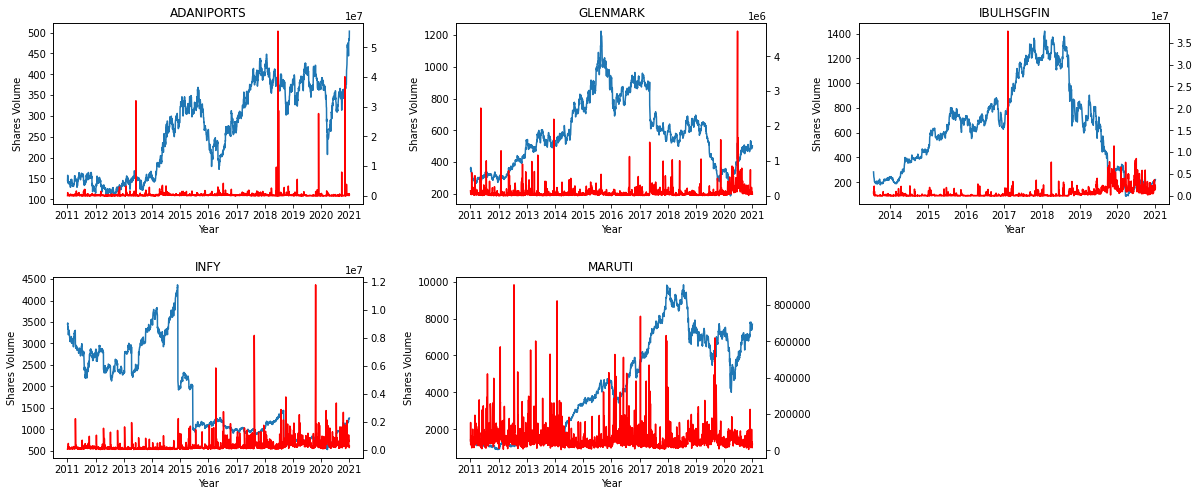

In [22]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)

for index, stock in enumerate(stock_list):
    ax = plt.subplot(2, 3, index+1)
    ax.set_xlabel("Year")
    ax.set_ylabel("Close Price")
    ax.plot(stock['Date'], stock['Close Price'])

    ax2=ax.twinx()
    ax2.plot(stock['Date'], stock['No.of Shares'], color='red')
    ax.set_ylabel("Shares Volume")
    plt.title(get_df_name(stock))
    
plt.subplots_adjust(hspace=0.4, wspace=0.3)   
plt.show()

>> ##### Heatmap

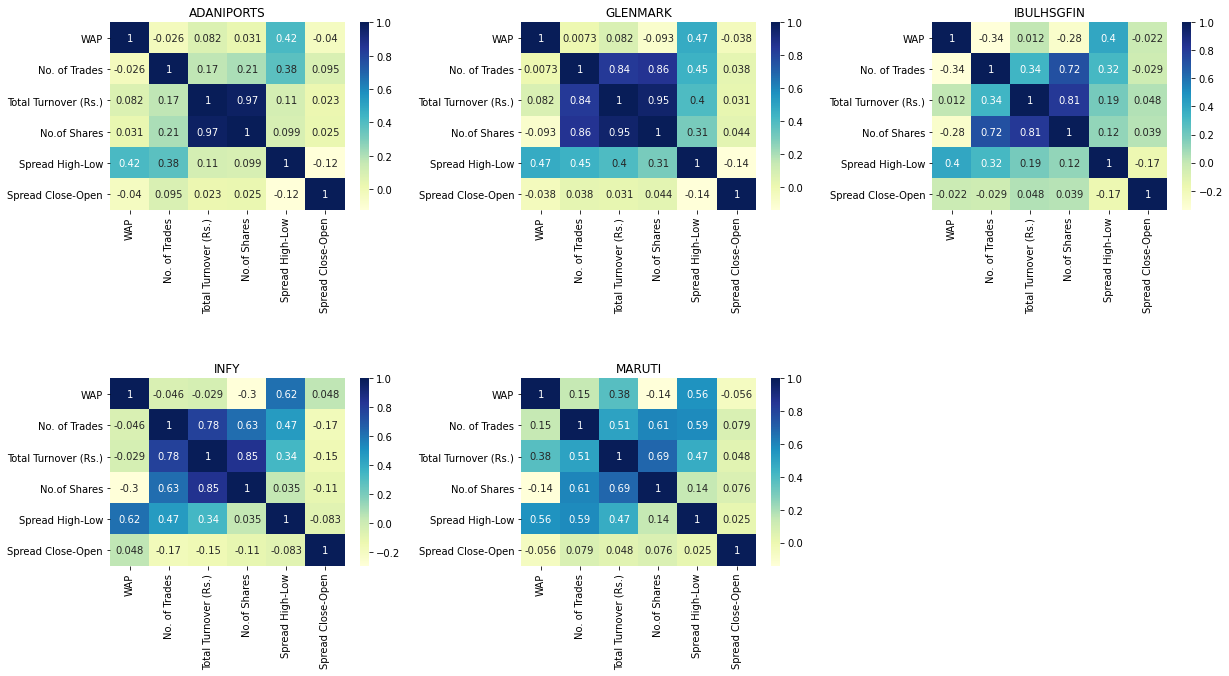

In [23]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

for index, stock in enumerate(stock_list):
    df = ["WAP", "No. of Trades", "Total Turnover (Rs.)", "No.of Shares", "Spread High-Low", "Spread Close-Open"]
    
    plt.subplot(2, 3, index+1)
    sns.heatmap(stock[df].corr(), annot = True, cmap="YlGnBu")
    plt.title(get_df_name(stock))
    
plt.subplots_adjust(hspace=0.9, wspace=0.4)   
plt.show()

> #### Data Preprocessing

>> ##### Remove unwanted columns

In [24]:
redundant_columns = ['Open Price', 'High Price', 'Low Price', 'No.of Shares', 'No. of Trades', 'Total Turnover (Rs.)', 'Deliverable Quantity', '% Deli. Qty to Traded Qty']

In [25]:
for stock in stock_list:
    stock.drop(columns=redundant_columns, inplace=True, axis=1, errors='ignore')
    get_stock_name(stock)
    display(stock.info())

ADANIPORTS
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2478 entries, 0 to 2478
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2478 non-null   datetime64[ns]
 1   Close Price        2478 non-null   float64       
 2   WAP                2478 non-null   float64       
 3   Spread High-Low    2478 non-null   float64       
 4   Spread Close-Open  2478 non-null   float64       
 5   MA for 20 days     2478 non-null   float64       
 6   MA for 50 days     2478 non-null   float64       
 7   MA for 100 days    2478 non-null   float64       
 8   MA for 200 days    2478 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 193.6 KB


None

GLENMARK
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2478 entries, 0 to 2478
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2478 non-null   datetime64[ns]
 1   Close Price        2478 non-null   float64       
 2   WAP                2478 non-null   float64       
 3   Spread High-Low    2478 non-null   float64       
 4   Spread Close-Open  2478 non-null   float64       
 5   MA for 20 days     2478 non-null   float64       
 6   MA for 50 days     2478 non-null   float64       
 7   MA for 100 days    2478 non-null   float64       
 8   MA for 200 days    2478 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 193.6 KB


None

IBULHSGFIN
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1839 entries, 0 to 1839
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1839 non-null   datetime64[ns]
 1   Close Price        1839 non-null   float64       
 2   WAP                1839 non-null   float64       
 3   Spread High-Low    1839 non-null   float64       
 4   Spread Close-Open  1839 non-null   float64       
 5   MA for 20 days     1839 non-null   float64       
 6   MA for 50 days     1839 non-null   float64       
 7   MA for 100 days    1839 non-null   float64       
 8   MA for 200 days    1839 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 143.7 KB


None

INFY
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2478 entries, 0 to 2478
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2478 non-null   datetime64[ns]
 1   Close Price        2478 non-null   float64       
 2   WAP                2478 non-null   float64       
 3   Spread High-Low    2478 non-null   float64       
 4   Spread Close-Open  2478 non-null   float64       
 5   MA for 20 days     2478 non-null   float64       
 6   MA for 50 days     2478 non-null   float64       
 7   MA for 100 days    2478 non-null   float64       
 8   MA for 200 days    2478 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 193.6 KB


None

MARUTI
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2478 entries, 0 to 2478
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2478 non-null   datetime64[ns]
 1   Close Price        2478 non-null   float64       
 2   WAP                2478 non-null   float64       
 3   Spread High-Low    2478 non-null   float64       
 4   Spread Close-Open  2478 non-null   float64       
 5   MA for 20 days     2478 non-null   float64       
 6   MA for 50 days     2478 non-null   float64       
 7   MA for 100 days    2478 non-null   float64       
 8   MA for 200 days    2478 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 193.6 KB


None

>> ##### Dataset Train-Test Split

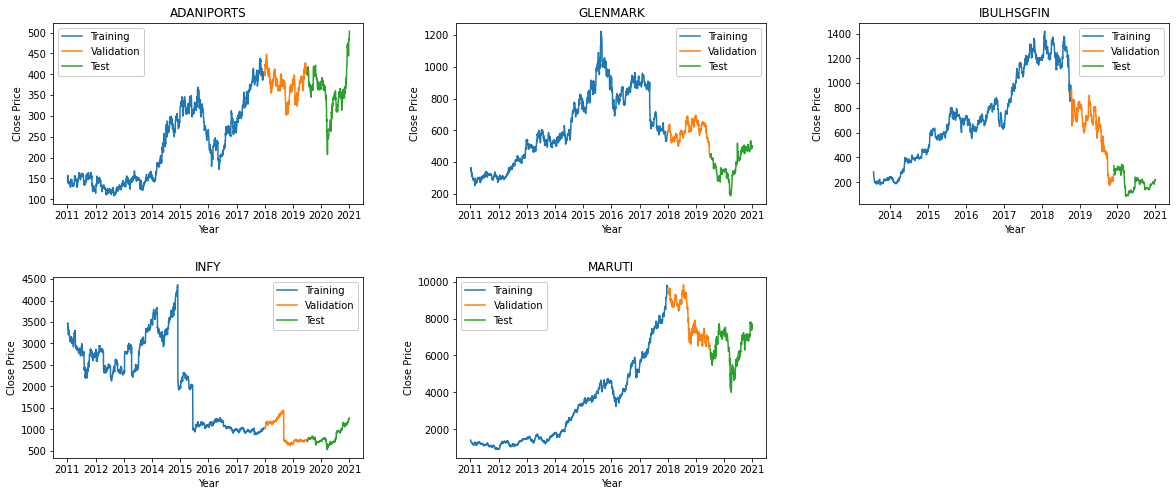

In [26]:
test_size  = 0.15
valid_size = 0.15

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)

Dict = {}

for index, stock in enumerate(stock_list):

    test_split_idx  = int(stock.shape[0] * (1-test_size))
    valid_split_idx = int(stock.shape[0] * (1-(valid_size+test_size)))

    train_df  = stock.loc[:valid_split_idx].copy()
    valid_df  = stock.loc[valid_split_idx+1:test_split_idx].copy()
    test_df   = stock.loc[test_split_idx+1:].copy()
    
    Dict[get_df_name(stock)] = {'train_df' : train_df, 'valid_df' : valid_df, 'test_df' : test_df}

    plt.subplot(2, 3, index+1)
    plt.xlabel('Year')
    plt.ylabel('Close Price')
    plt.plot(train_df.Date, train_df['Close Price'], label='Training')
    plt.plot(valid_df.Date, valid_df['Close Price'], label='Validation')
    plt.plot(test_df.Date, test_df['Close Price'],  label='Test')
    plt.title(get_df_name(stock))
    plt.legend(framealpha=1, frameon=True);

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

> #### Models

In [27]:
# Sending data to model
def send_data_to_model(stock, model):
    if model == 'lstm':
        lstm_model(stock, get_df_name(stock))
    else:
        data = Dict[get_df_name(stock)]
        xgb_model(data['train_df'], data['valid_df'], data['test_df'], get_df_name(stock))

# Mean Bias Error
def MBE(y_true, y_pred):
    '''
    Parameters:
        y_true (array): Array of observed values
        y_pred (array): Array of prediction values

    Returns:
        mbe (float): Bias score
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = y_true.reshape(len(y_true),1)
    y_pred = y_pred.reshape(len(y_pred),1)   
    diff = (y_true-y_pred)
    mbe = diff.mean()
    return mbe

# Model Evaluation Metrics
def print_model_metrics(y_test, y_pred, model_name):
    print(model_name+" Model Stats Scores Summary : ")
    
    r2 = round(r2_score(y_test,y_pred),2)
    rmse = round(mean_squared_error(y_test, y_pred, squared=False),2)
    mape = round(mean_absolute_percentage_error(y_test, y_pred),2)
    mbe = round(MBE(y_test, y_pred),2)
    
    data = [[model_name, r2, rmse, mape, mbe]] 
    df = pd.DataFrame(data, columns = ['Model', 'R2 Score', 'RMSE', 'MAPE', 'MBE'])
    return df

def zoomed_chart(data_test, y_test_unscaled, y_pred, stock_name):
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(5)

    plt.plot(data_test['Date'], y_test_unscaled, label = 'Real Stock Price')
    plt.plot(data_test['Date'], y_pred, color = 'red', label = 'Predicted Stock Price')
    plt.title(stock_name + ' Stock Price Actual vs. Predicted')
    plt.xlabel('Year')
    plt.ylabel('Close Price')
    plt.legend()

    plt.grid()
    plt.show()
    
def full_chart(data_train, data_test, y_test_unscaled, y_pred, stock_name):
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(5)

    plt.plot(data_train['Date'], data_train['Close Price'], color = "#039dfc", label = 'Train')
    plt.plot(data_test['Date'], y_test_unscaled, color = 'green', label = 'Real Stock Price')
    plt.plot(data_test['Date'], y_pred, color = 'red', label = 'Predicted Stock Price')
    plt.title(stock_name + ' Stock Price Actual vs. Predicted With Train Data')
    plt.xlabel('Year')
    plt.ylabel('Close Price')
    plt.legend()

    plt.grid()
    plt.show()

>> ##### LSTM Multivariate (Long Short-Term Memory)

In [ ]:
# Loss Plot Function
def plot_loss(history, epochs):
    fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
    plt.plot(history.history["loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
    plt.legend(["Train", "Test"], loc="upper left")
    plt.grid()
    plt.show()

>>> ###### LSTM Model Build Function

In [ ]:
def lstm_model(stock, stock_name):
    
    # Indexing Batches
    train_df = stock.copy()
        
    # List of considered Features
    FEATURES = ['Close Price', 'WAP', 'Spread High-Low', 'Spread Close-Open', 'MA for 20 days', 
            'MA for 50 days', 'MA for 100 days', 'MA for 200 days']
    
    # Create the dataset with features and filter the data to the list of FEATURES
    data = pd.DataFrame(train_df)
    data_filtered = data[FEATURES]
    
    # Get the number of rows in the data
    nrows = data_filtered.shape[0]

    # Convert the data to numpy values
    np_data_unscaled = np.array(data_filtered)
    np_data = np.reshape(np_data_unscaled, (nrows, -1))

    # Transform the data by scaling each feature to a range between 0 and 1
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(np_data_unscaled)

    # Creating a separate scaler that works on a single column for scaling predictions
    scaler_pred = MinMaxScaler()
    df_Close = pd.DataFrame(data_filtered['Close Price'])
    np_Close_scaled = scaler_pred.fit_transform(df_Close)
    
    # Set the sequence length - this is the timeframe used to make a single prediction
    sequence_length = 50

    # Prediction Index
    index_Close = data.columns.get_loc("Close Price")

    # Split the training data into train and train data sets
    train_data_len = math.ceil(np_data_scaled.shape[0] * 0.85)

    # Create the training and test data
    train_data = np_data_scaled[0:train_data_len, :]
    test_data = np_data_scaled[train_data_len - sequence_length:, :]

    # Here, we create N samples, sequence_length time-steps per sample, and 8 features
    def partition_dataset(sequence_length, data):
        x, y = [], []
        data_len = data.shape[0]
        for i in range(sequence_length, data_len):
            x.append(data[i-sequence_length:i,:])
            y.append(data[i, index_Close])

        # Convert the x and y to numpy arrays
        x = np.array(x)
        y = np.array(y)
        return x, y

    # Generate training data and test data
    x_train, y_train = partition_dataset(sequence_length, train_data)
    x_test, y_test = partition_dataset(sequence_length, test_data)

    # Print the shapes
    print('\033[1m' + 'Train and Test Shape' + '\033[0m')
    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)
    print('\n')
    
    # Configure the neural network model
    regressor = Sequential()

    # Model with n_neurons = inputshape Timestamps
    n_neurons = x_train.shape[1] * x_train.shape[2]
    print('\033[1m' + 'Neurons | Input Shape' + '\033[0m')
    print(n_neurons, x_train.shape[1], x_train.shape[2])
    print('\n')
    
    regressor.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    
    regressor.add(LSTM(n_neurons, return_sequences=False))
                  
    regressor.add(Dense(5))
    regressor.add(Dense(1))
    
    print('\033[1m' + 'LSTM Build Model Summary' + '\033[0m')
    display(regressor.summary())

    # Compile the model
    regressor.compile(optimizer='adam', loss='mse')
    
    # Training the model
    epochs = 50
    batch_size = 20
    history = regressor.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs,
                        validation_split=0.15,
                       )
    
    # Plot training & validation loss values
    plot_loss(history, epochs)
    
    # Get the predicted values
    y_pred_scaled = regressor.predict(x_test)
    
    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
    
    # Evaluation Metrics
    display(print_model_metrics(y_test_unscaled, y_pred, 'LSTM'))
    
    #-------------------------------------------------------------------------#
    
    # Add the date column
    data_filtered_sub = data_filtered.copy()
    data_filtered_sub['Date'] = train_df['Date']
    
    data_train = data_filtered_sub[:train_data_len + 1]
    
    n = 15 # percent of dataset to be used for test
    data_test = train_df.tail(int(len(train_df)*(n/100)))
    
    # Zoomed Chart Data - Focused Test Data
    zoomed_chart(data_test, y_test_unscaled, y_pred, stock_name)
    
    # Chart Data - Whole Dataset
    full_chart(data_train, data_test, y_test_unscaled, y_pred, stock_name)
    

ADANIPORTS


None

Train and Test Shape
(2057, 50, 8) (2057,)
(371, 50, 8) (371,)


Neurons | Input Shape
400 50 8


LSTM Build Model Summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 400)           654400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dense (Dense)                (None, 5)                 2005      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 1,938,011
Trainable params: 1,938,011
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/50
88/88 [==============================] - 20s 29ms/step - loss: 0.0323 - val_loss: 0.0021
Epoch 2/50
88/88 [==============================] - 1s 12ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 3/50
88/88 [==============================] - 1s 12ms/step - loss: 7.7469e-04 - val_loss: 9.3614e-04
Epoch 4/50
88/88 [==============================] - 1s 12ms/step - loss: 5.9434e-04 - val_loss: 0.0014
Epoch 5/50
88/88 [==============================] - 1s 12ms/step - loss: 6.2293e-04 - val_loss: 6.1735e-04
Epoch 6/50
88/88 [==============================] - 1s 13ms/step - loss: 3.7483e-04 - val_loss: 8.2219e-04
Epoch 7/50
88/88 [==============================] - 1s 13ms/step - loss: 3.3821e-04 - val_loss: 4.1935e-04
Epoch 8/50
88/88 [==============================] - 1s 12ms/step - loss: 3.5528e-04 - val_loss: 4.6935e-04
Epoch 9/50
88/88 [==============================] - 1s 13ms/step - loss: 2.6486e-04 - val_loss: 5.3745e-04
Epoch 10/50
88/88 [==============================] - 1s 

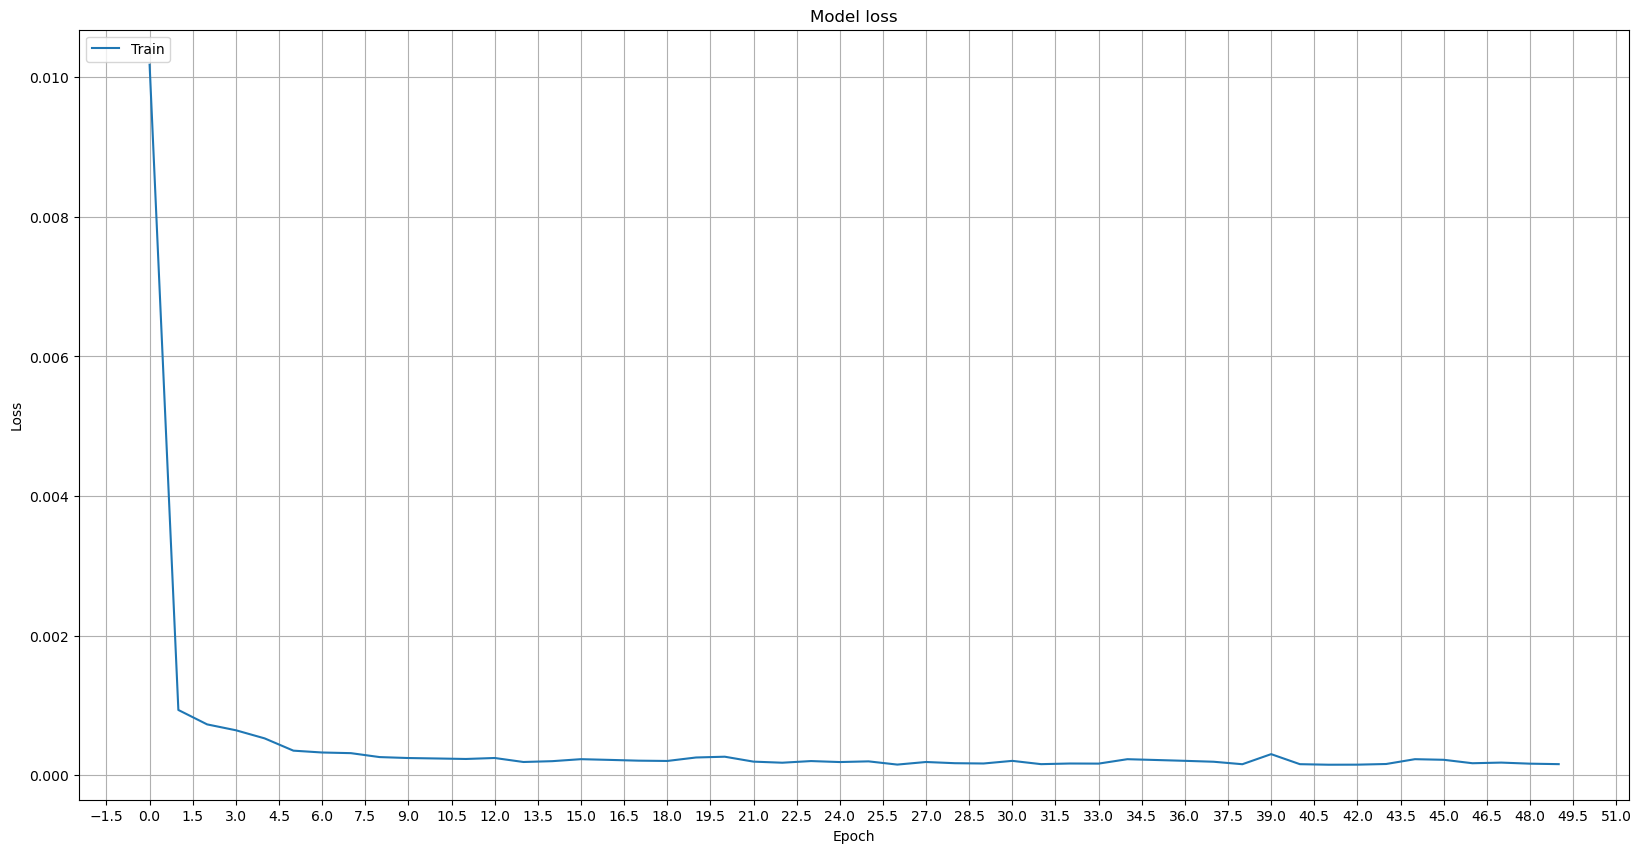

LSTM Model Stats Scores Summary : 


,Model,R2 Score,RMSE,MAPE,MBE
0,LSTM,0.98,7.31,0.02,-0.54


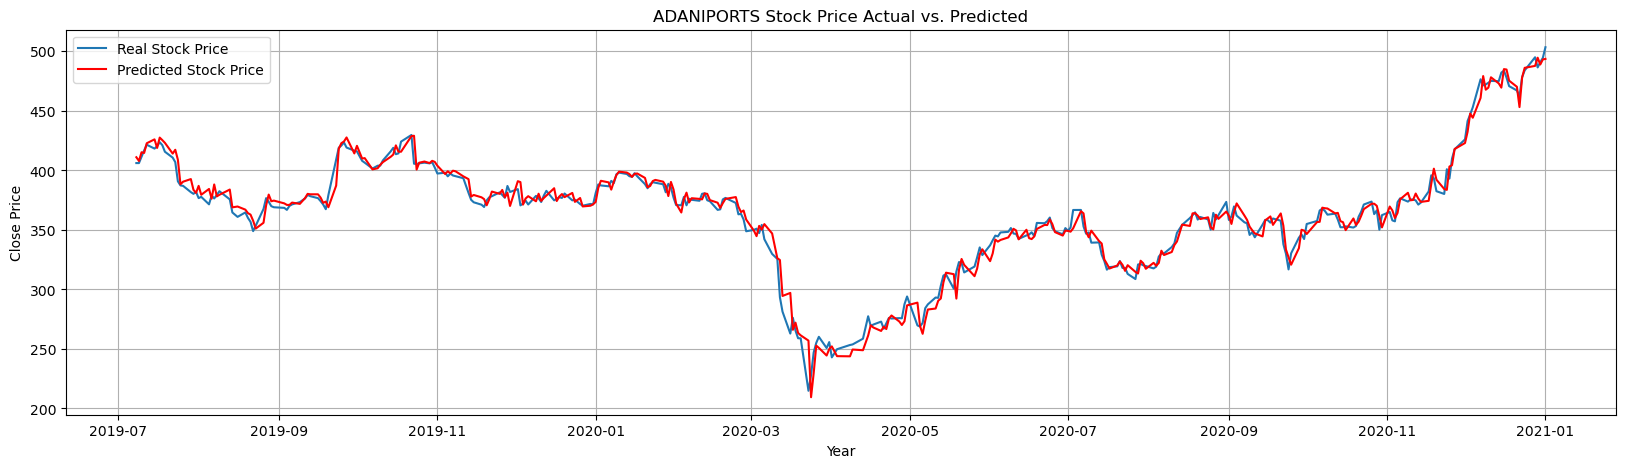

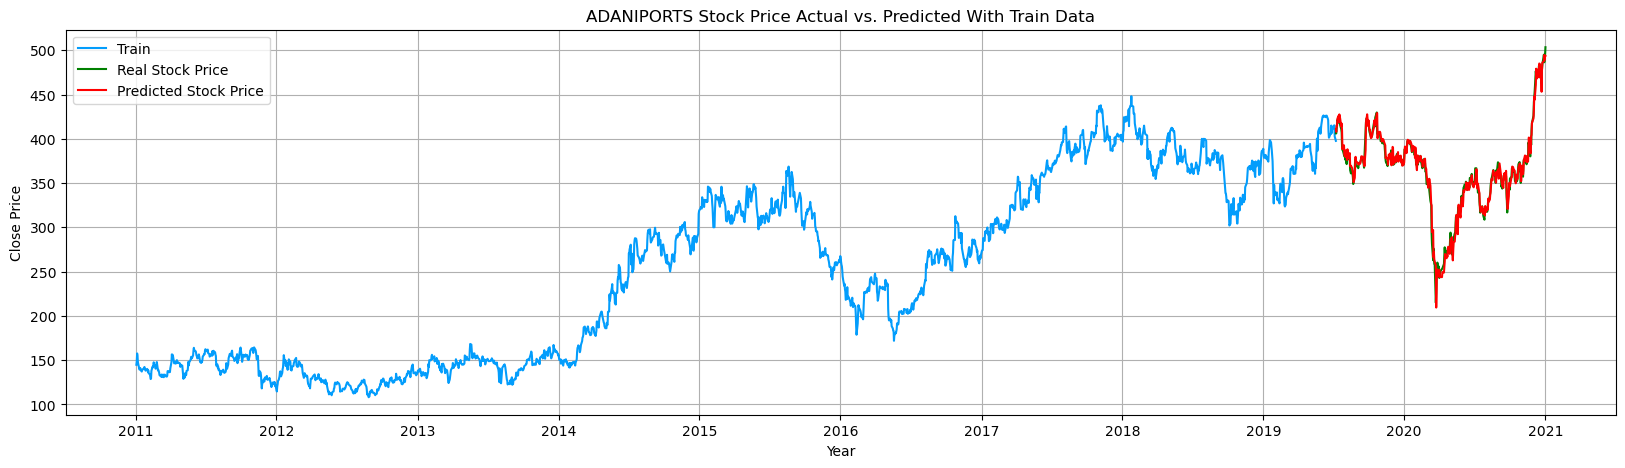

---

GLENMARK


None

Train and Test Shape
(2057, 50, 8) (2057,)
(371, 50, 8) (371,)


Neurons | Input Shape
400 50 8


LSTM Build Model Summary
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 400)           654400    
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2005      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,938,011
Trainable params: 1,938,011
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/50
88/88 [==============================] - 4s 21ms/step - loss: 0.0723 - val_loss: 0.0013
Epoch 2/50
88/88 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 8.7756e-04
Epoch 3/50
88/88 [==============================] - 1s 13ms/step - loss: 9.7224e-04 - val_loss: 8.7496e-04
Epoch 4/50
88/88 [==============================] - 1s 13ms/step - loss: 7.3124e-04 - val_loss: 4.9707e-04
Epoch 5/50
88/88 [==============================] - 1s 13ms/step - loss: 5.5130e-04 - val_loss: 2.0162e-04
Epoch 6/50
88/88 [==============================] - 1s 13ms/step - loss: 3.7290e-04 - val_loss: 2.1759e-04
Epoch 7/50
88/88 [==============================] - 1s 13ms/step - loss: 4.0521e-04 - val_loss: 1.7473e-04
Epoch 8/50
88/88 [==============================] - 1s 13ms/step - loss: 3.1191e-04 - val_loss: 0.0011
Epoch 9/50
88/88 [==============================] - 1s 13ms/step - loss: 4.7216e-04 - val_loss: 1.3487e-04
Epoch 10/50
88/88 [==============================] - 

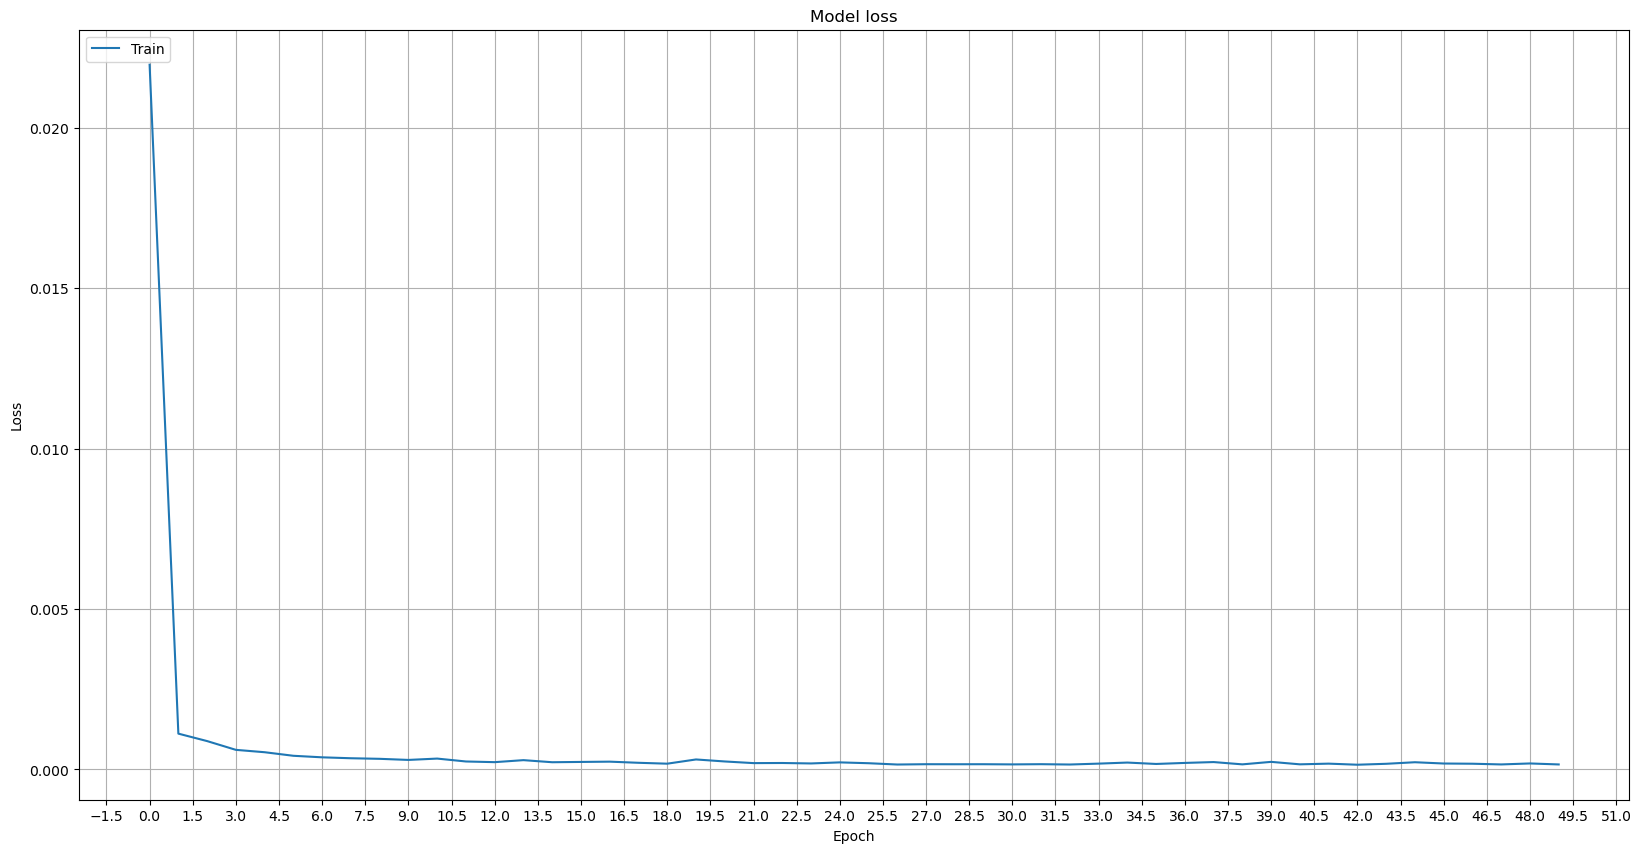

LSTM Model Stats Scores Summary : 


,Model,R2 Score,RMSE,MAPE,MBE
0,LSTM,0.97,15.38,0.03,10.2


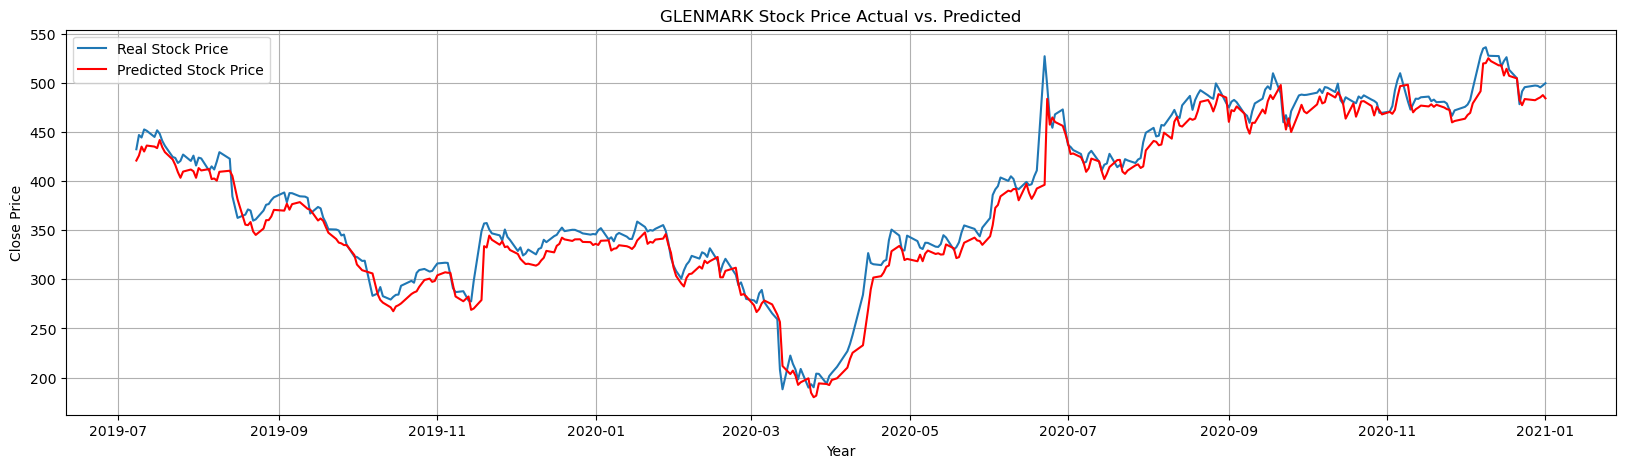

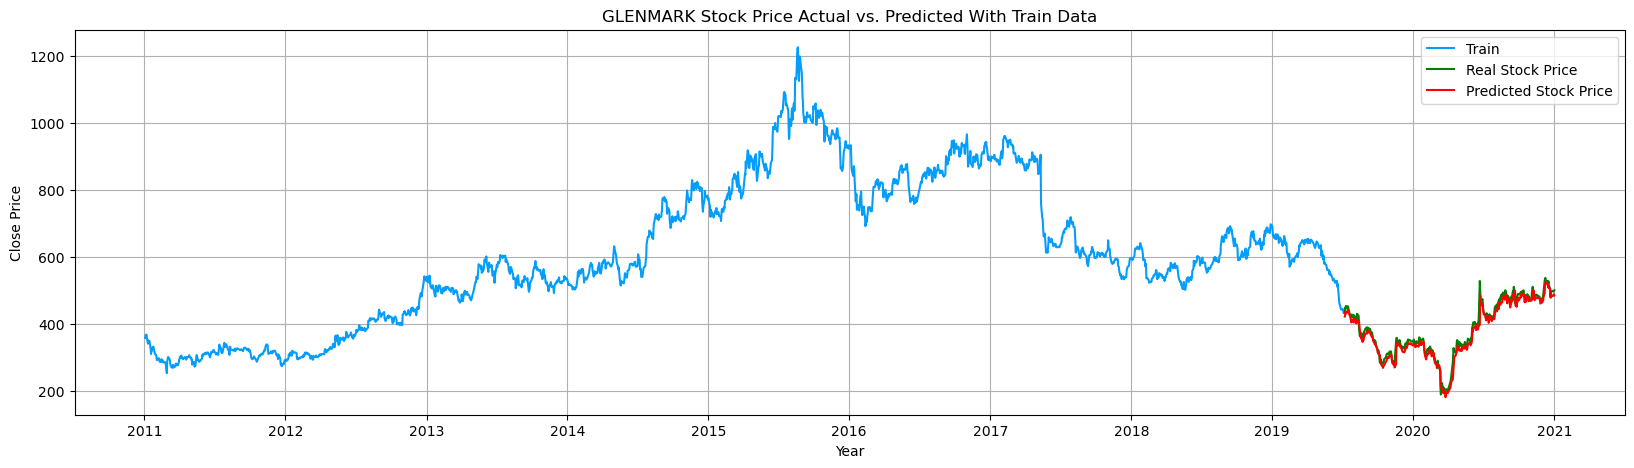

---

IBULHSGFIN


None

Train and Test Shape
(1514, 50, 8) (1514,)
(275, 50, 8) (275,)


Neurons | Input Shape
400 50 8


LSTM Build Model Summary
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 400)           654400    
_________________________________________________________________
lstm_5 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 2005      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 1,938,011
Trainable params: 1,938,011
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/50
65/65 [==============================] - 4s 24ms/step - loss: 0.0544 - val_loss: 0.0027
Epoch 2/50
65/65 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 3/50
65/65 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 4/50
65/65 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/50
65/65 [==============================] - 1s 13ms/step - loss: 6.5403e-04 - val_loss: 0.0011
Epoch 6/50
65/65 [==============================] - 1s 13ms/step - loss: 5.8633e-04 - val_loss: 0.0012
Epoch 7/50
65/65 [==============================] - 1s 13ms/step - loss: 6.1002e-04 - val_loss: 7.7045e-04
Epoch 8/50
65/65 [==============================] - 1s 13ms/step - loss: 4.4334e-04 - val_loss: 6.4174e-04
Epoch 9/50
65/65 [==============================] - 1s 13ms/step - loss: 5.9051e-04 - val_loss: 0.0012
Epoch 10/50
65/65 [==============================] - 1s 13ms/step - loss: 4.0164e

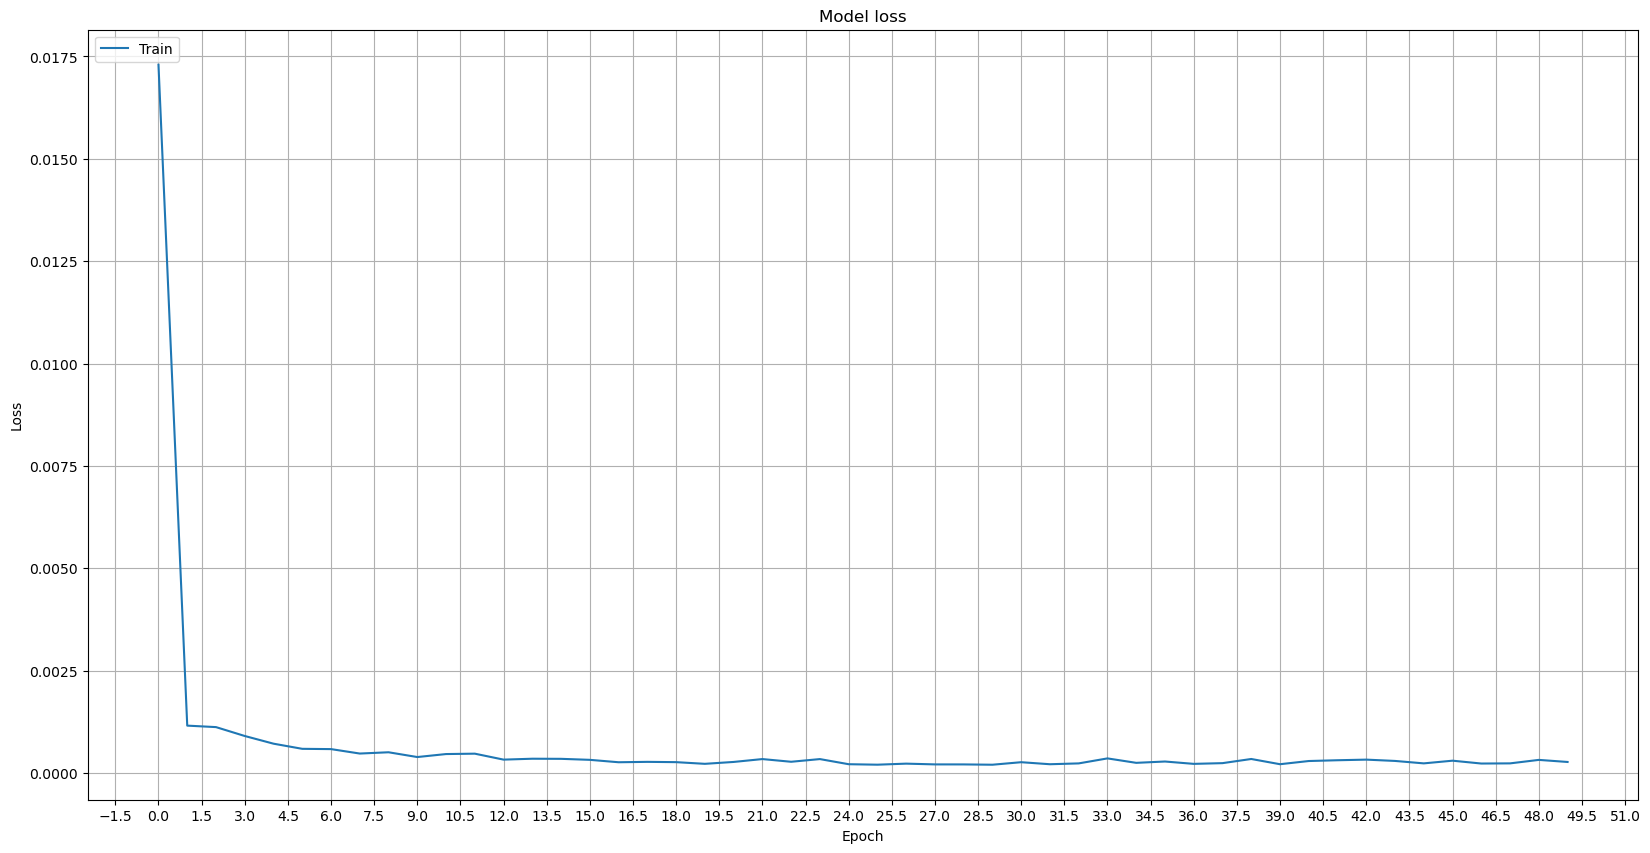

LSTM Model Stats Scores Summary : 


,Model,R2 Score,RMSE,MAPE,MBE
0,LSTM,0.98,10.54,0.04,1.26


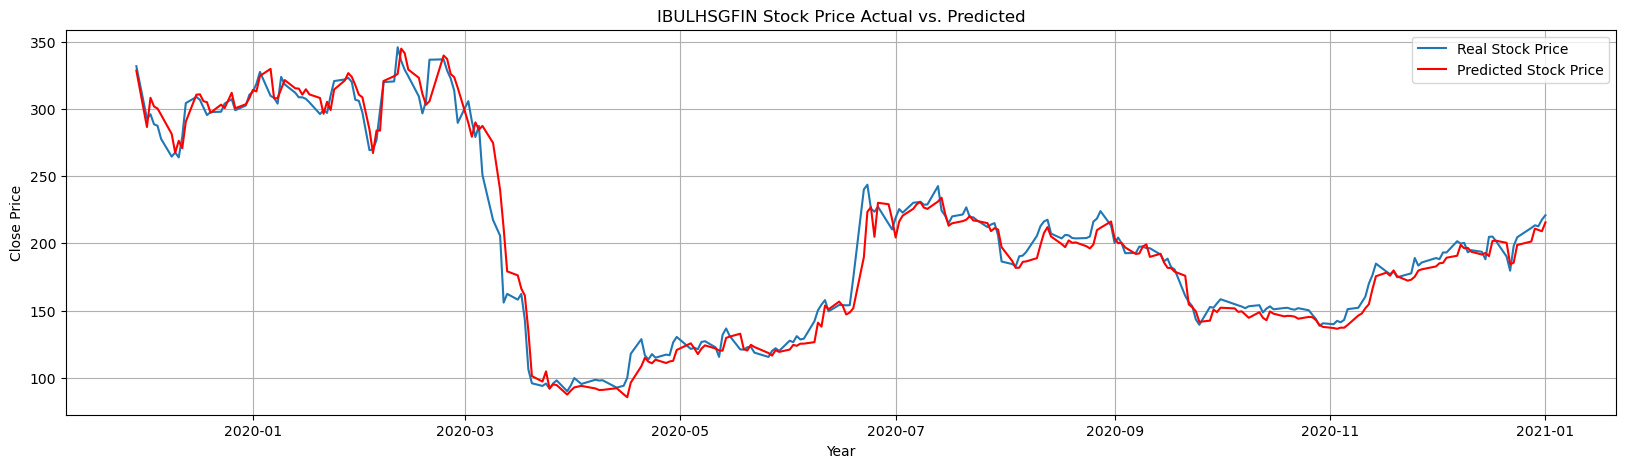

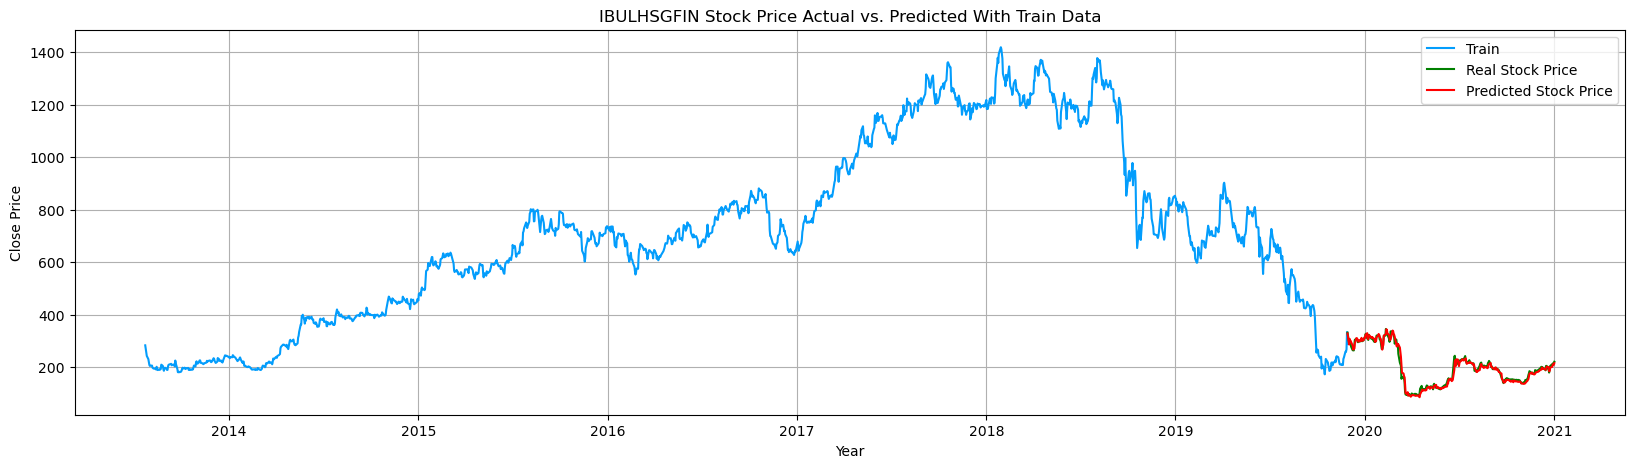

---

INFY


None

Train and Test Shape
(2057, 50, 8) (2057,)
(371, 50, 8) (371,)


Neurons | Input Shape
400 50 8


LSTM Build Model Summary
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50, 400)           654400    
_________________________________________________________________
lstm_7 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 2005      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 1,938,011
Trainable params: 1,938,011
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/50
88/88 [==============================] - 4s 21ms/step - loss: 0.1205 - val_loss: 7.4514e-04
Epoch 2/50
88/88 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 5.3106e-04
Epoch 3/50
88/88 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 5.4777e-04
Epoch 4/50
88/88 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 3.9344e-04
Epoch 5/50
88/88 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 4.4797e-04
Epoch 6/50
88/88 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 3.1490e-04
Epoch 7/50
88/88 [==============================] - 1s 13ms/step - loss: 8.3485e-04 - val_loss: 3.5480e-04
Epoch 8/50
88/88 [==============================] - 1s 13ms/step - loss: 8.8068e-04 - val_loss: 2.8187e-04
Epoch 9/50
88/88 [==============================] - 1s 13ms/step - loss: 3.5403e-04 - val_loss: 2.6203e-04
Epoch 10/50
88/88 [==============================] - 1s 13ms/

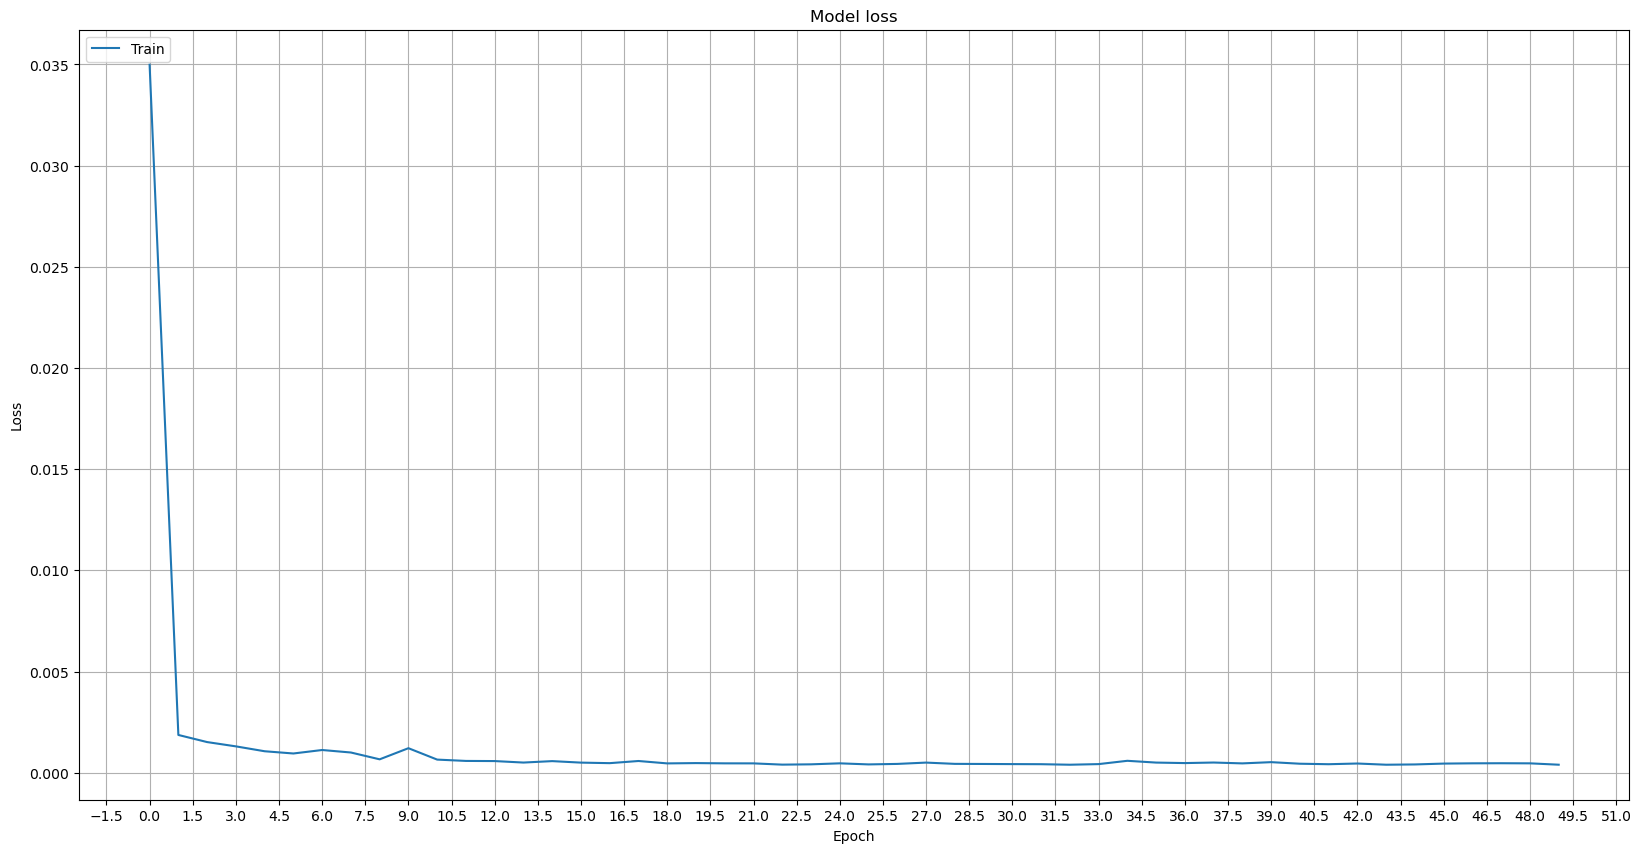

LSTM Model Stats Scores Summary : 


,Model,R2 Score,RMSE,MAPE,MBE
0,LSTM,0.91,51.7,0.06,-47.92


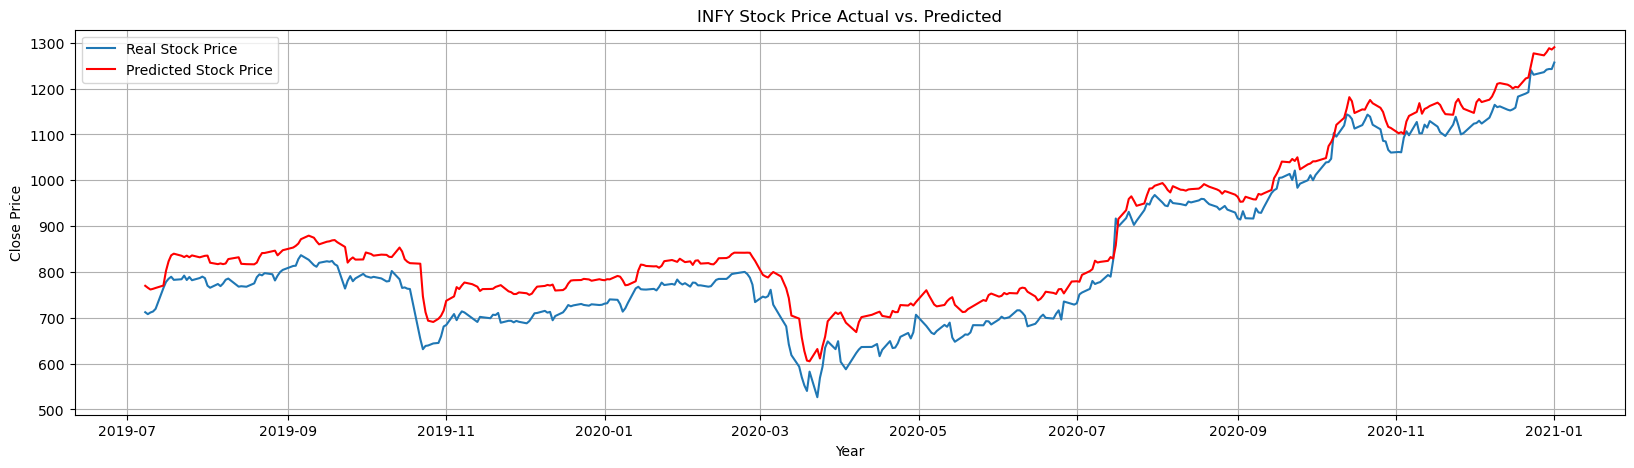

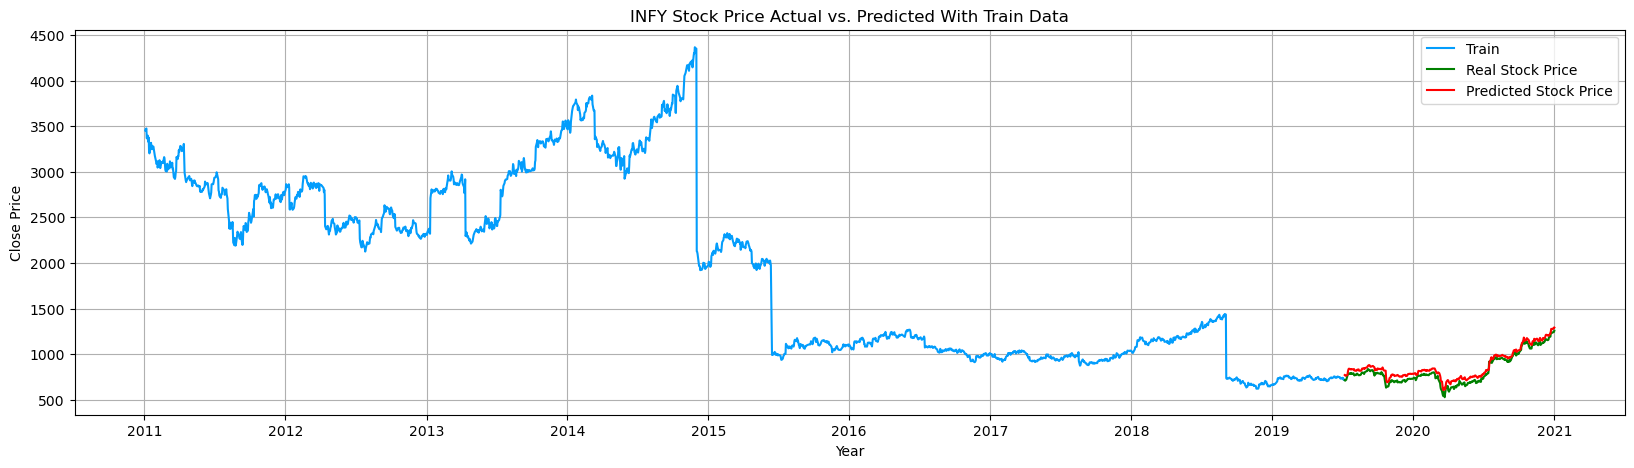

---

MARUTI


None

Train and Test Shape
(2057, 50, 8) (2057,)
(371, 50, 8) (371,)


Neurons | Input Shape
400 50 8


LSTM Build Model Summary
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 50, 400)           654400    
_________________________________________________________________
lstm_9 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 2005      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 1,938,011
Trainable params: 1,938,011
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/50
88/88 [==============================] - 4s 22ms/step - loss: 0.0115 - val_loss: 0.0015
Epoch 2/50
88/88 [==============================] - 1s 13ms/step - loss: 3.0438e-04 - val_loss: 0.0012
Epoch 3/50
88/88 [==============================] - 1s 13ms/step - loss: 2.5834e-04 - val_loss: 0.0020
Epoch 4/50
88/88 [==============================] - 1s 13ms/step - loss: 2.0420e-04 - val_loss: 5.9467e-04
Epoch 5/50
88/88 [==============================] - 1s 13ms/step - loss: 1.7941e-04 - val_loss: 6.0683e-04
Epoch 6/50
88/88 [==============================] - 1s 13ms/step - loss: 1.4084e-04 - val_loss: 9.1550e-04
Epoch 7/50
88/88 [==============================] - 1s 13ms/step - loss: 2.3877e-04 - val_loss: 0.0019
Epoch 8/50
88/88 [==============================] - 1s 13ms/step - loss: 1.9171e-04 - val_loss: 2.9046e-04
Epoch 9/50
88/88 [==============================] - 1s 13ms/step - loss: 8.4164e-05 - val_loss: 2.2252e-04
Epoch 10/50
88/88 [==============================] - 1s 1

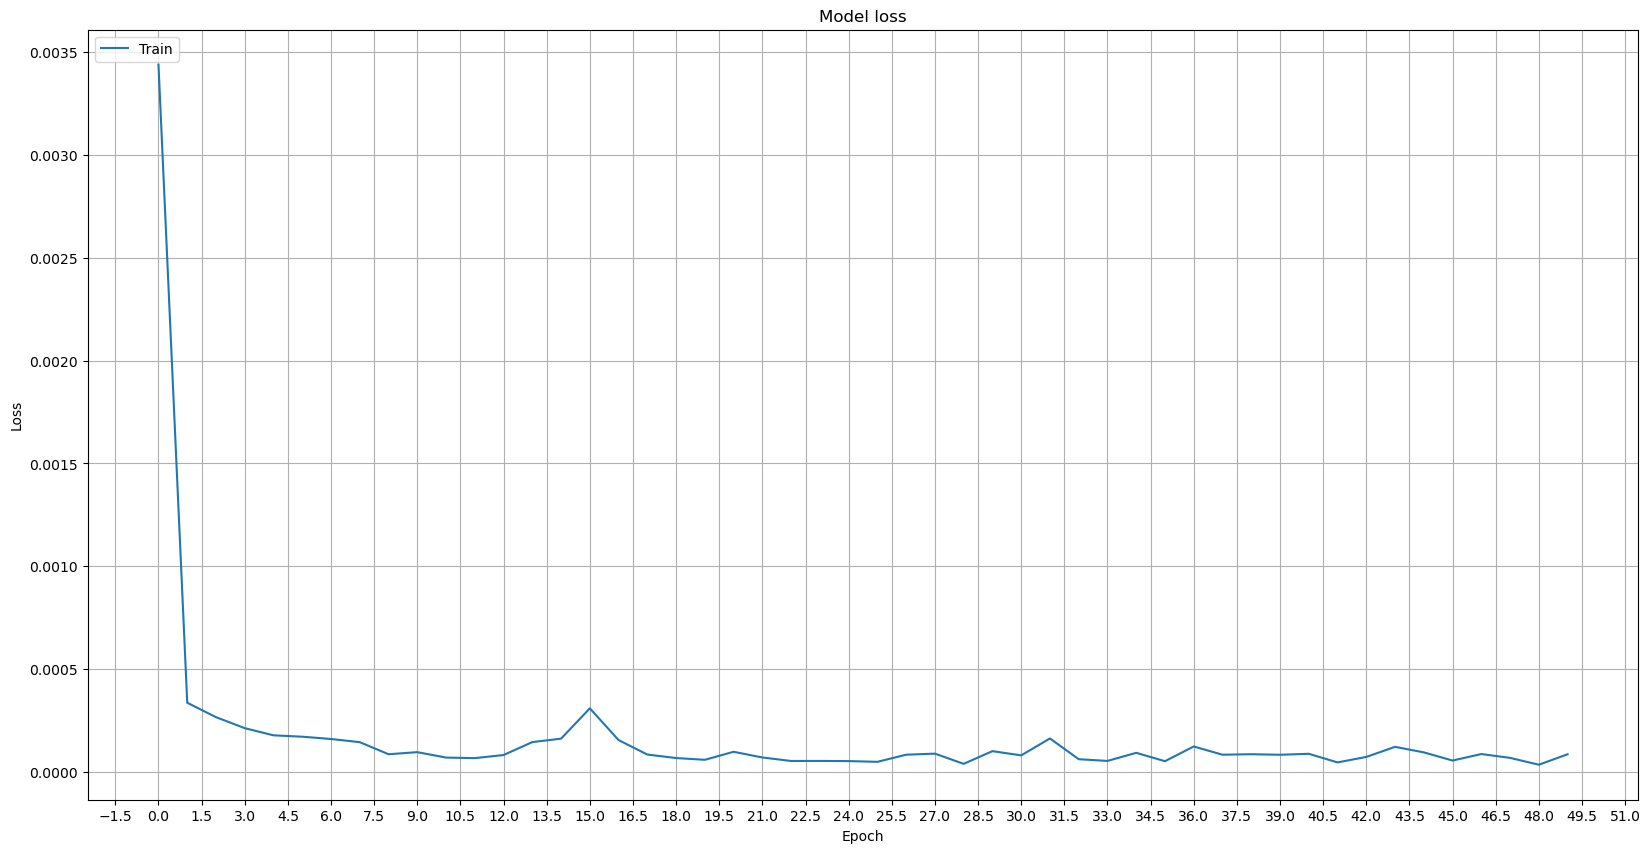

LSTM Model Stats Scores Summary : 


,Model,R2 Score,RMSE,MAPE,MBE
0,LSTM,0.98,119.72,0.01,-18.57


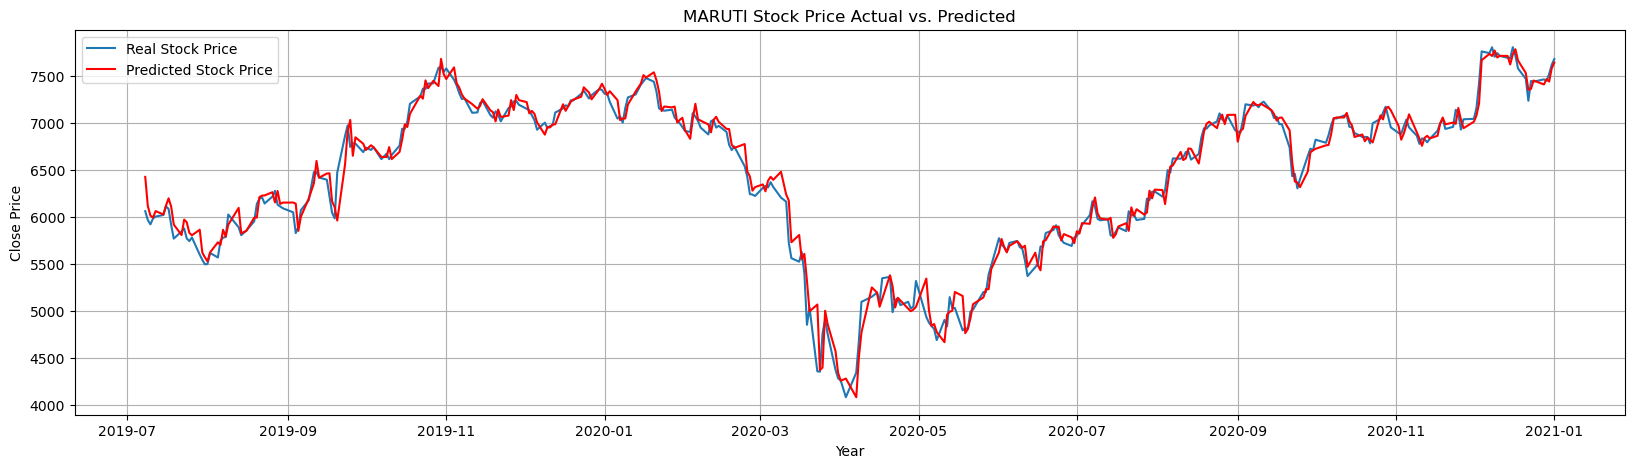

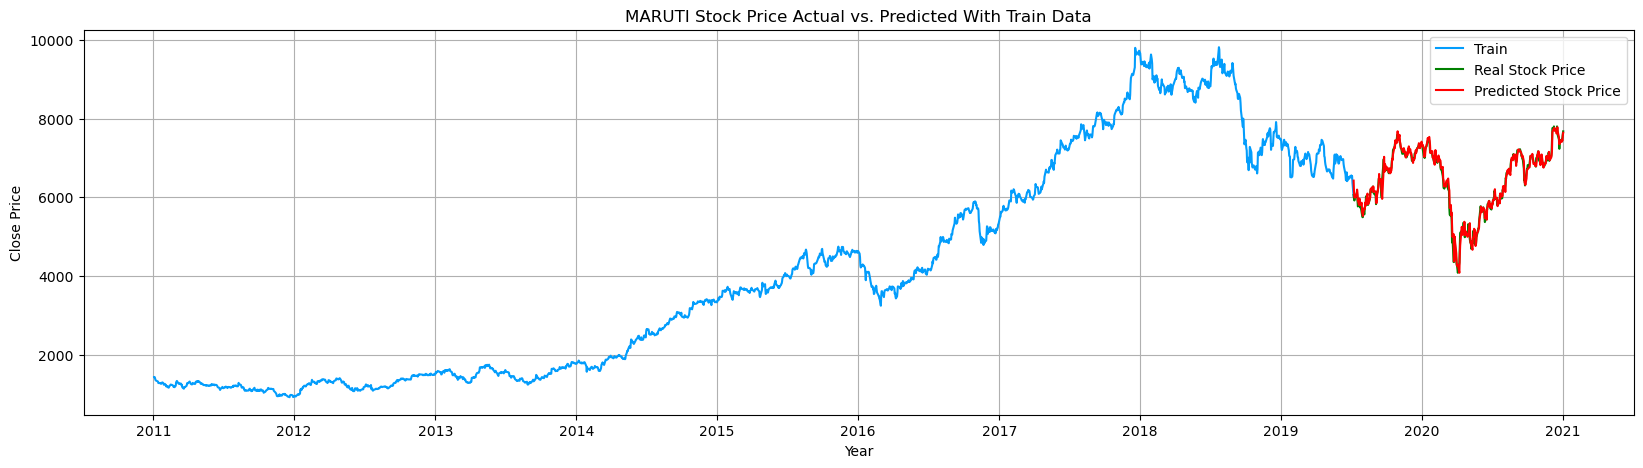

---

CPU times: user 5min 19s, sys: 24.1 s, total: 5min 43s
Wall time: 5min 26s


In [ ]:
%%time

for index, stock in enumerate(stock_list):
    display(get_stock_name(stock))
    send_data_to_model(stock, 'lstm')
    display(Markdown('---'))

>> ##### XGBoost (eXtreme Gradient Boosting)

>>> ###### XGBoost Model Build Function

In [ ]:
xgb.set_config(verbosity=3)

In [28]:
def xgb_model(train_df, valid_df, test_df, stock_name):
    
    # Train + Valid Data
    data_train = [train_df, valid_df]
    data_train = pd.concat(data_train)
    
    # Test Data
    data_test = test_df
    
    # Drop unwanted columns
    drop_cols = ['Date']

    train_df = train_df.drop(drop_cols, 1)
    valid_df = valid_df.drop(drop_cols, 1)
    test_df  = test_df.drop(drop_cols, 1)
    
    # Split into features and labels
    y_train = train_df['Close Price'].copy()
    X_train = train_df.drop(['Close Price'], 1)

    y_valid = valid_df['Close Price'].copy()
    X_valid = valid_df.drop(['Close Price'], 1)

    y_test  = test_df['Close Price'].copy()
    X_test  = test_df.drop(['Close Price'], 1)

    display(X_train.info())
    
    # Fine-tune XGBoostRegressor
    
#         'n_estimators': [300, 400],
#         'learning_rate': [0.01, 0.05],
#         'max_depth': [12, 15],
#         'gamma': [0.001, 0.005],
    parameters = {
        'n_estimators': [300, 400],
        'learning_rate': [0.01, 0.05],
        'max_depth': [12, 15],
        'gamma': [0.001, 0.005],
        'random_state': [42]
    }

    eval_set = [(X_train, y_train), (X_valid, y_valid)]
    fit_params = {'eval_set' : eval_set}
    model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=3)
    clf = GridSearchCV(estimator = model, param_grid = parameters, n_jobs = -1, verbose = 10)
    display(clf)
    
    clf.fit(X_train, y_train, **fit_params)

    print(f'Best params: {clf.best_params_}')
    print(f'Best validation score = {clf.best_score_}')
    
    # Final model whith chosen parameters
    model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
    model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    
    # Feature Importance
    plot_importance(model);
    
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Evaluation Metrics
    display(print_model_metrics(y_test, y_pred, 'XGBoost'))
    
    # Zoomed Chart Data - Focused Test Data
    zoomed_chart(data_test, y_test, y_pred, stock_name)
    
    # Chart Data - Whole Dataset
    full_chart(data_train, data_test, y_test, y_pred, stock_name)

ADANIPORTS


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1734 entries, 0 to 1734
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   WAP                1734 non-null   float64
 1   Spread High-Low    1734 non-null   float64
 2   Spread Close-Open  1734 non-null   float64
 3   MA for 20 days     1734 non-null   float64
 4   MA for 50 days     1734 non-null   float64
 5   MA for 100 days    1734 non-null   float64
 6   MA for 200 days    1734 non-null   float64
dtypes: float64(7)
memory usage: 108.4 KB


None

GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', verbosity=3),
             n_jobs=-1,
             param_grid={'gamma': [0.001, 0.005], 'learning_rate': [0.01, 0.05],
                         'max_depth': [12, 15], 'n_estimators': [300, 400],
                         'random_state': [42]},
             verbose=10)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[10:57:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation_0-rmse:228.1	validation_1-rmse:359.003
[10:57:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation_0-rmse:216.782	validation_1-rmse:341.255
[10:57:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	validation_0-rmse:206.027	validation_1-rmse:324.448
[10:57:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-rmse:195.804	validation_1-rmse:308.283
[10:57:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-rmse:186.092	validation_1-rmse:293.309
[10:57:28] INFO:

,Model,R2 Score,RMSE,MAPE,MBE
0,XGBoost,0.97,8.96,0.01,2.16


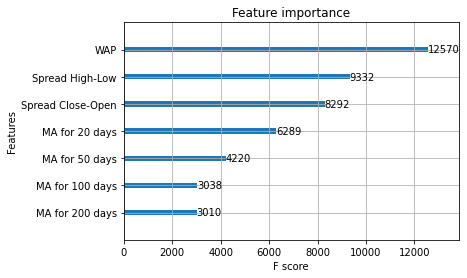

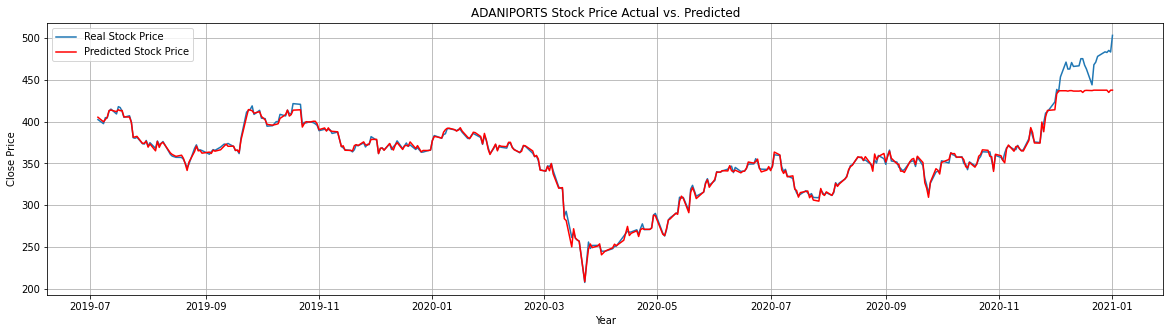

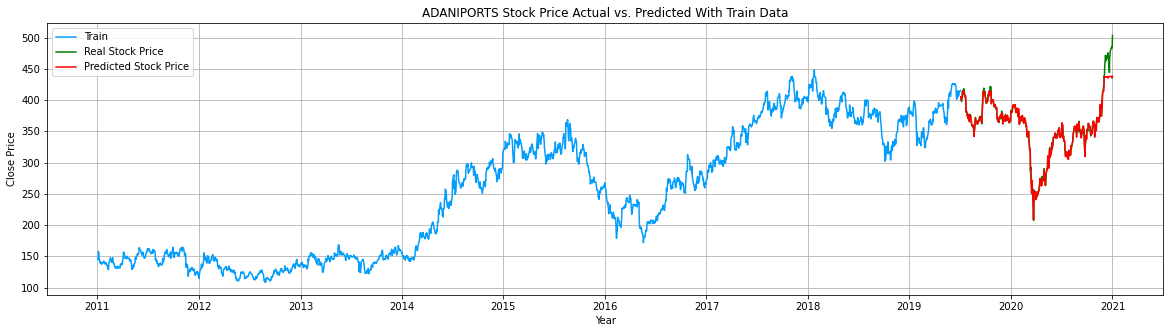

---

GLENMARK


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1734 entries, 0 to 1734
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   WAP                1734 non-null   float64
 1   Spread High-Low    1734 non-null   float64
 2   Spread Close-Open  1734 non-null   float64
 3   MA for 20 days     1734 non-null   float64
 4   MA for 50 days     1734 non-null   float64
 5   MA for 100 days    1734 non-null   float64
 6   MA for 200 days    1734 non-null   float64
dtypes: float64(7)
memory usage: 108.4 KB


None

GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', verbosity=3),
             n_jobs=-1,
             param_grid={'gamma': [0.001, 0.005], 'learning_rate': [0.01, 0.05],
                         'max_depth': [12, 15], 'n_estimators': [300, 400],
                         'random_state': [42]},
             verbose=10)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[10:58:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation_0-rmse:652.13	validation_1-rmse:592.175
[10:58:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation_0-rmse:645.654	validation_1-rmse:586.256
[10:58:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[2]	validation_0-rmse:639.243	validation_1-rmse:580.417
[10:58:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[3]	validation_0-rmse:632.896	validation_1-rmse:574.655
[10:58:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[4]	validation_0-rmse:626.612	validation_1-rmse:568.916
[10:58:53] INFO

,Model,R2 Score,RMSE,MAPE,MBE
0,XGBoost,0.93,21.19,0.05,16.0


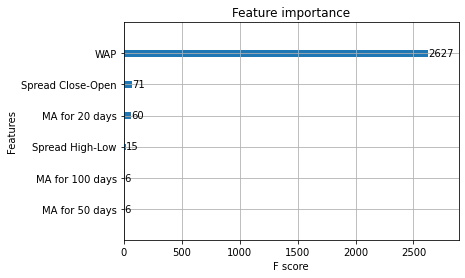

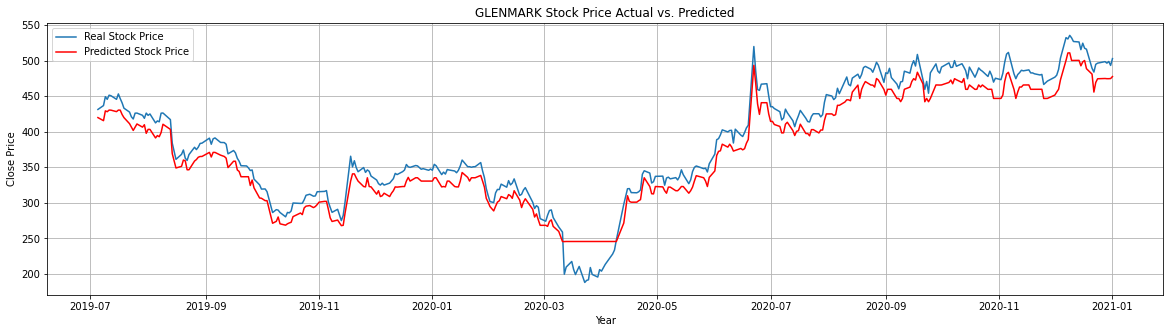

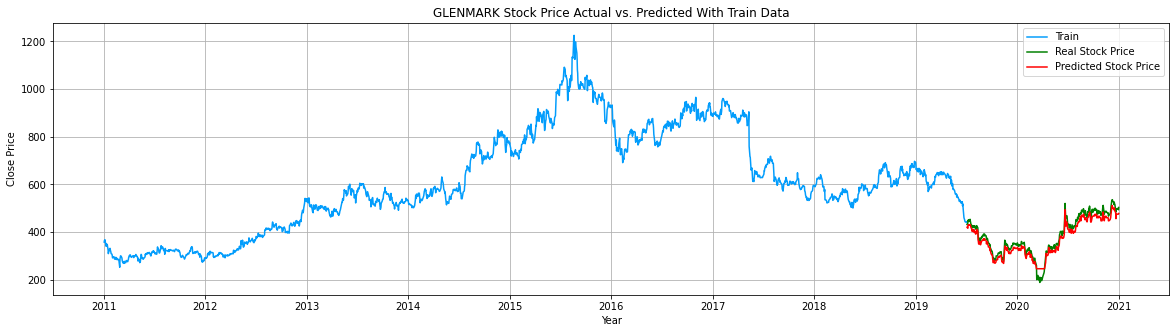

---

IBULHSGFIN


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1287 entries, 0 to 1287
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   WAP                1287 non-null   float64
 1   Spread High-Low    1287 non-null   float64
 2   Spread Close-Open  1287 non-null   float64
 3   MA for 20 days     1287 non-null   float64
 4   MA for 50 days     1287 non-null   float64
 5   MA for 100 days    1287 non-null   float64
 6   MA for 200 days    1287 non-null   float64
dtypes: float64(7)
memory usage: 80.4 KB


None

GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', verbosity=3),
             n_jobs=-1,
             param_grid={'gamma': [0.001, 0.005], 'learning_rate': [0.01, 0.05],
                         'max_depth': [12, 15], 'n_estimators': [300, 400],
                         'random_state': [42]},
             verbose=10)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[11:00:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-rmse:773.443	validation_1-rmse:623.547
[11:00:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-rmse:735.106	validation_1-rmse:592.556
[11:00:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-rmse:698.678	validation_1-rmse:562.895
[11:00:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-rmse:664.056	validation_1-rmse:534.791
[11:00:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[4]	validation_0-rmse:631.143	validation_1-rmse:498.983
[11:00:02] INF

,Model,R2 Score,RMSE,MAPE,MBE
0,XGBoost,0.76,33.72,0.16,-19.2


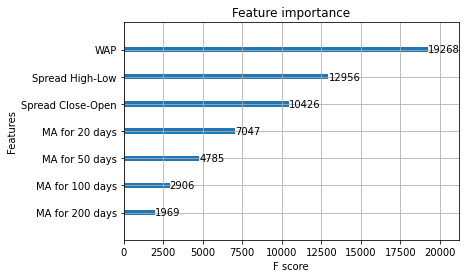

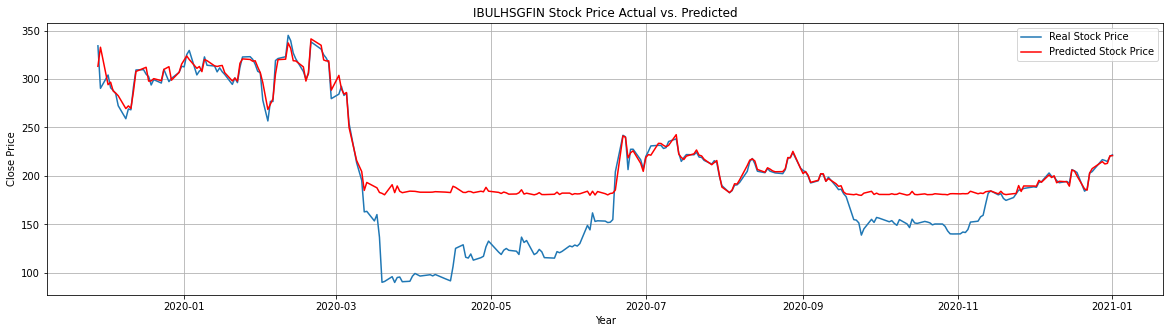

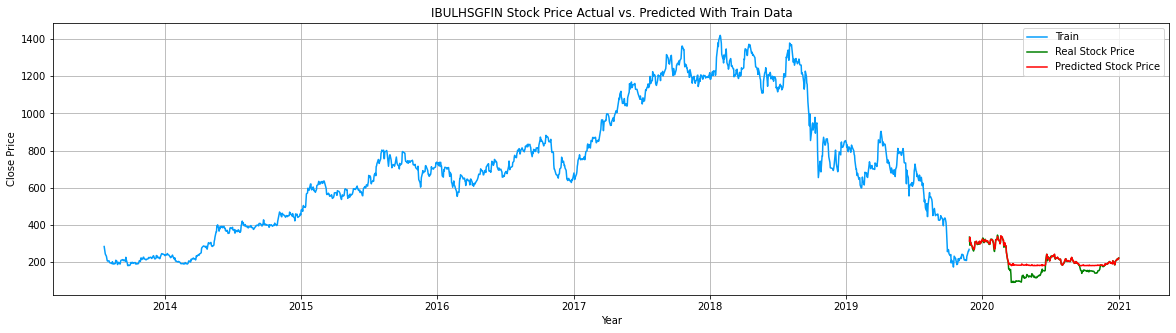

---

INFY


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1734 entries, 0 to 1734
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   WAP                1734 non-null   float64
 1   Spread High-Low    1734 non-null   float64
 2   Spread Close-Open  1734 non-null   float64
 3   MA for 20 days     1734 non-null   float64
 4   MA for 50 days     1734 non-null   float64
 5   MA for 100 days    1734 non-null   float64
 6   MA for 200 days    1734 non-null   float64
dtypes: float64(7)
memory usage: 108.4 KB


None

GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', verbosity=3),
             n_jobs=-1,
             param_grid={'gamma': [0.001, 0.005], 'learning_rate': [0.01, 0.05],
                         'max_depth': [12, 15], 'n_estimators': [300, 400],
                         'random_state': [42]},
             verbose=10)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[11:01:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-rmse:2251.67	validation_1-rmse:924.622
[11:01:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-rmse:2139.84	validation_1-rmse:876.358
[11:01:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-rmse:2033.64	validation_1-rmse:830.489
[11:01:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-rmse:1932.65	validation_1-rmse:787.503
[11:01:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-rmse:1836.72	validation_1-rmse:746.079
[11:01:25] INF

,Model,R2 Score,RMSE,MAPE,MBE
0,XGBoost,0.37,133.51,0.15,-100.87


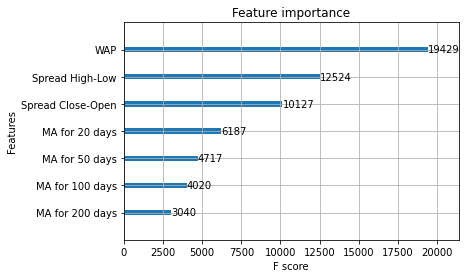

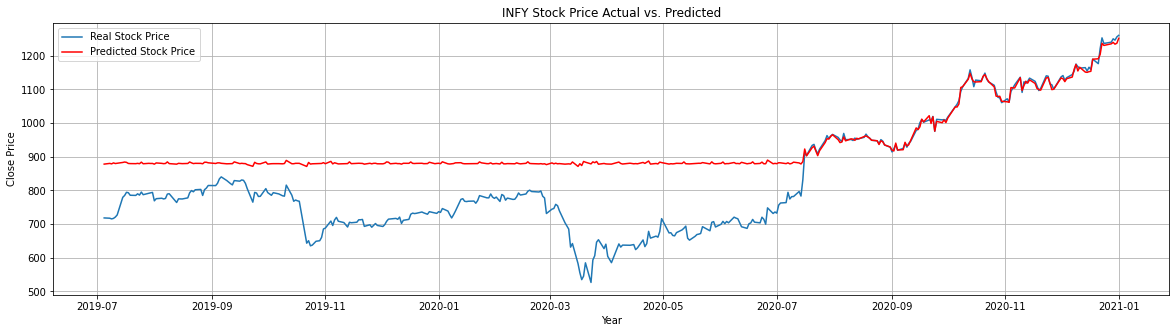

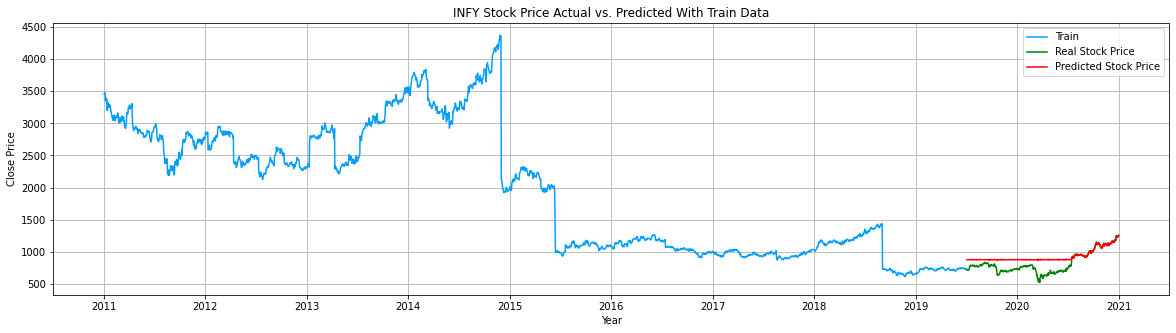

---

MARUTI


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1734 entries, 0 to 1734
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   WAP                1734 non-null   float64
 1   Spread High-Low    1734 non-null   float64
 2   Spread Close-Open  1734 non-null   float64
 3   MA for 20 days     1734 non-null   float64
 4   MA for 50 days     1734 non-null   float64
 5   MA for 100 days    1734 non-null   float64
 6   MA for 200 days    1734 non-null   float64
dtypes: float64(7)
memory usage: 108.4 KB


None

GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', verbosity=3),
             n_jobs=-1,
             param_grid={'gamma': [0.001, 0.005], 'learning_rate': [0.01, 0.05],
                         'max_depth': [12, 15], 'n_estimators': [300, 400],
                         'random_state': [42]},
             verbose=10)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[11:02:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation_0-rmse:3636.29	validation_1-rmse:7693.45
[11:02:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-rmse:3456.7	validation_1-rmse:7322.8
[11:02:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation_0-rmse:3286.04	validation_1-rmse:6988.94
[11:02:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-rmse:3123.8	validation_1-rmse:6664.33
[11:02:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[4]	validation_0-rmse:2969.61	validation_1-rmse:6361.18
[11:02:52] INFO: 

,Model,R2 Score,RMSE,MAPE,MBE
0,XGBoost,0.99,60.06,0.01,-18.28


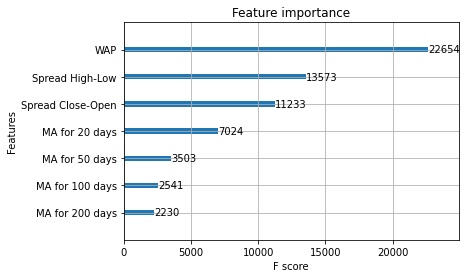

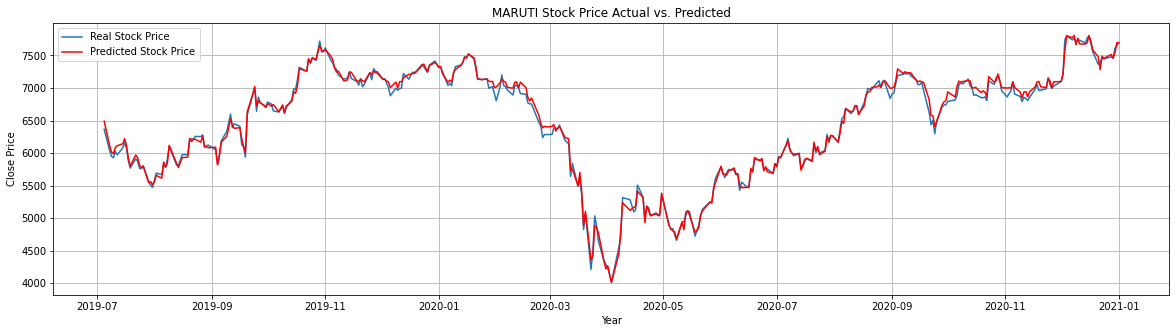

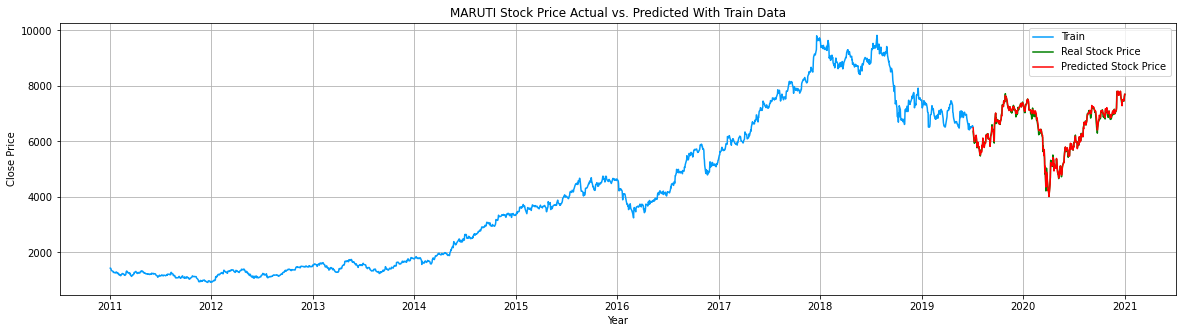

---

CPU times: user 33 s, sys: 1.78 s, total: 34.7 s
Wall time: 6min 52s


In [29]:
%%time

for index, stock in enumerate(stock_list):
    display(get_stock_name(stock))
    send_data_to_model(stock, 'xgboost')
    display(Markdown('---'))

> ### The results look great!
>
> - It can be clearly seen the LSTM model performs better than XGBoost.
> - The above point proves that Deep Learning models are much better in stock price prediction than ML models
> - The past 10 years data is highly effective in forecasting future prices.
> - Using above model we can recommend traders the stocks to buy/sell for next business day
> - Voume traded plays vital role in stock price changes an it's clearly seen above while analyzing data
> - Volume Weighted Average Price (VWAP) and Close Price are correlated to each other.
> - The analysis on data during time period of demonetization and covid shows that it highly impacted the share market and stock prices of listed companies.
>
>  *End*